In [2]:
import numpy as np

from framework.SMS import import_dataset_fromSMS, plot_graph_from_adjacency_matrix

datasetSMS = import_dataset_fromSMS("data/SMS/wavy3-500/")

sim = list(datasetSMS.keys())[0]
origial_adjacency_matrix = datasetSMS[sim]['adjacency_matrix']
num_nodes = origial_adjacency_matrix.shape[0]

def poison_adjacency_matrix_symmetric(adj_matrix: np.ndarray, x_percent: float, y_percent: float) -> tuple[np.ndarray, list[tuple[int, int]]]:
    """
    Poison a percentage of non-null links in a NumPy adjacency matrix, preserving symmetry.
    When a link (r, c) is poisoned, its symmetric counterpart (c, r) is also poisoned.

    Args:
        adj_matrix (np.ndarray): The input symmetric adjacency matrix (values between 0 and 1).
        x_percent (float): The percentage of unique non-null links (above the diagonal) to consider for poisoning.
        y_percent (float): The amount to poison by (e.g., 10 for 10% of the link value).

    Returns:
        tuple[np.ndarray, list[tuple[int, int]]]: A tuple containing:
            - The poisoned symmetric adjacency matrix.
            - A list of (row, col) tuples representing the indices of ALL modified links (including symmetric pairs).
    """
    if not (0 <= x_percent <= 100):
        raise ValueError("x_percent must be between 0 and 100.")
    if not (0 <= y_percent):
        raise ValueError("y_percent must be a non-negative value.")
    if not np.allclose(adj_matrix, adj_matrix.T):
        raise ValueError("Input adjacency matrix must be symmetric to preserve symmetry.")
    if not np.all((adj_matrix >= 0) & (adj_matrix <= 1)):
        raise ValueError("All values in the adjacency matrix must be between 0 and 1.")

    poisoned_adj_matrix = adj_matrix.copy()
    modified_indices = []

    # Get all unique non-zero link indices (above the main diagonal to avoid duplicates and self-loops)
    # We consider (r, c) where r < c
    upper_tri_non_null_indices = np.argwhere(np.triu(adj_matrix, k=1) != 0)

    if len(upper_tri_non_null_indices) == 0:
        return poisoned_adj_matrix, modified_indices

    # Calculate the number of unique links to poison
    num_unique_links_to_poison = int(len(upper_tri_non_null_indices) * (x_percent / 100))

    if num_unique_links_to_poison == 0 and x_percent > 0:
        print(f"Warning: No links were poisoned as {x_percent}% of {len(upper_tri_non_null_indices)} unique non-null links is less than 1.")
        return poisoned_adj_matrix, modified_indices

    # Randomly select unique indices to poison from the upper triangle
    if num_unique_links_to_poison > 0:
        actual_num_to_poison = min(num_unique_links_to_poison, len(upper_tri_non_null_indices))

        selected_unique_indices_flat_idx = np.random.choice(
            len(upper_tri_non_null_indices), actual_num_to_poison, replace=False
        )
        selected_unique_indices = upper_tri_non_null_indices[selected_unique_indices_flat_idx]

        # Poison the selected unique links and their symmetric counterparts
        for r, c in selected_unique_indices:
            # Poison (r, c)
            original_value_rc = poisoned_adj_matrix[r, c]
            poison_amount_rc = original_value_rc * (y_percent / 100)

            # Randomly decide to increase or decrease
            if np.random.rand() < 0.5:
                new_value_rc = original_value_rc + poison_amount_rc
            else:
                new_value_rc = original_value_rc - poison_amount_rc

            new_value_rc = np.clip(new_value_rc, 0, 1)

            if new_value_rc != original_value_rc:
                poisoned_adj_matrix[r, c] = new_value_rc
                modified_indices.append((r, c))

            # Poison (c, r) by the EXACT SAME amount and direction as (r, c)
            # The original_value_cr should be equal to original_value_rc due to initial symmetry
            original_value_cr = poisoned_adj_matrix[c, r] # This should be the same as original_value_rc
            
            # Recalculate poison_amount_cr based on new_value_rc if you want to be precise,
            # but the goal is to make it symmetric, so directly use new_value_rc for (c,r)
            poisoned_adj_matrix[c, r] = new_value_rc
            
            # Only add (c, r) to modified_indices if its value actually changed
            # (which it should if (r,c) changed, assuming it started symmetric)
            if new_value_rc != original_value_cr:
                modified_indices.append((c, r))

    return poisoned_adj_matrix, modified_indices


poisoned_adjacency_matrix, poisoned_indices = poison_adjacency_matrix_symmetric(origial_adjacency_matrix, 20, 70)
datasetSMS[sim]['adjacency_matrix'] = poisoned_adjacency_matrix


p_vectors_array = datasetSMS[sim]['p_array']
dimP = p_vectors_array.shape[1]

def read_matrix_from_csv_loadtxt(filepath, delimiter=','):
  """
  Reads a NumPy matrix from a CSV file using np.loadtxt().

  Args:
    filepath (str): The path to the CSV file.
    delimiter (str): The character separating values in the CSV file (default is comma).

  Returns:
    numpy.ndarray: The matrix read from the CSV file.
  """
  try:
    matrix = np.loadtxt(filepath, delimiter=delimiter)
    print(f"Successfully loaded matrix from {filepath} using np.loadtxt().")
    return matrix
  except FileNotFoundError:
    print(f"Error: The file '{filepath}' was not found.")
    return None
  except Exception as e:
    print(f"An error occurred while loading the file: {e}")
    return None

path = "data/SMS/wavy3-500/sim_" + str(sim) + "/wavy3_p_matrix.csv"
p_vectors_array = (read_matrix_from_csv_loadtxt(path))
dimP = p_vectors_array.shape[1]
for x in datasetSMS.values():
    x["p_array"]=p_vectors_array


from framework.trainFct import *
from torch_geometric.data import Data, DataLoader
from framework.visuals import *

latent_dim = 2
input_dim = dimP
batch_size = 16

encoder_hidden_dims=[128, 64, 32]
adj_decoder_hidden_dims=[64, 64, 32]
node_decoder_hidden_dims=[64, 64, 32]
gcn_layers=3
fc_layers=2

dataset = []
for x in datasetSMS.values():
    # Create PyG data object
    data = Data(x=torch.tensor(x["p_array"], dtype=torch.float), 
                edge_index=adj_matrix_to_edge_index(x["adjacency_matrix"])[0], 
                edge_labels=adj_matrix_to_edge_index(x["adjacency_matrix"])[1],
                adjacency_matrix=torch.tensor(x["adjacency_matrix"]))
    dataset.append(data)

# Select a single graph to train on
single_graph = dataset[0]

# Wrap in list for compatibility with DataLoader-like expectations
single_graph_list = [single_graph]

from framework.boundedManifold import BoundedManifold

def local_decoder_point_metric(z, model):
    """
    Wrapper to compute the Riemannian metric from the jacobian matrix
    z: numpy array with shape (n,)
    
    Returns an (n x n) metric tensor.
    """
    G = None
    try:
        J = model.compute_jacobian(torch.unsqueeze(torch.tensor(z, dtype=torch.float),0), "node_attr_decoder", 0)
        G = np.matmul(J.T, J)
            
    except Exception as e:
        print(f"Error at grid point ({z}): {e}")
    return G.numpy()

Successfully loaded matrix from data/SMS/wavy3-500/sim_7583/wavy3_p_matrix.csv using np.loadtxt().


/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

=== Starting Phase 1: Training encoder with node feature reconstruction ===

=== Phase 1 Complete ===


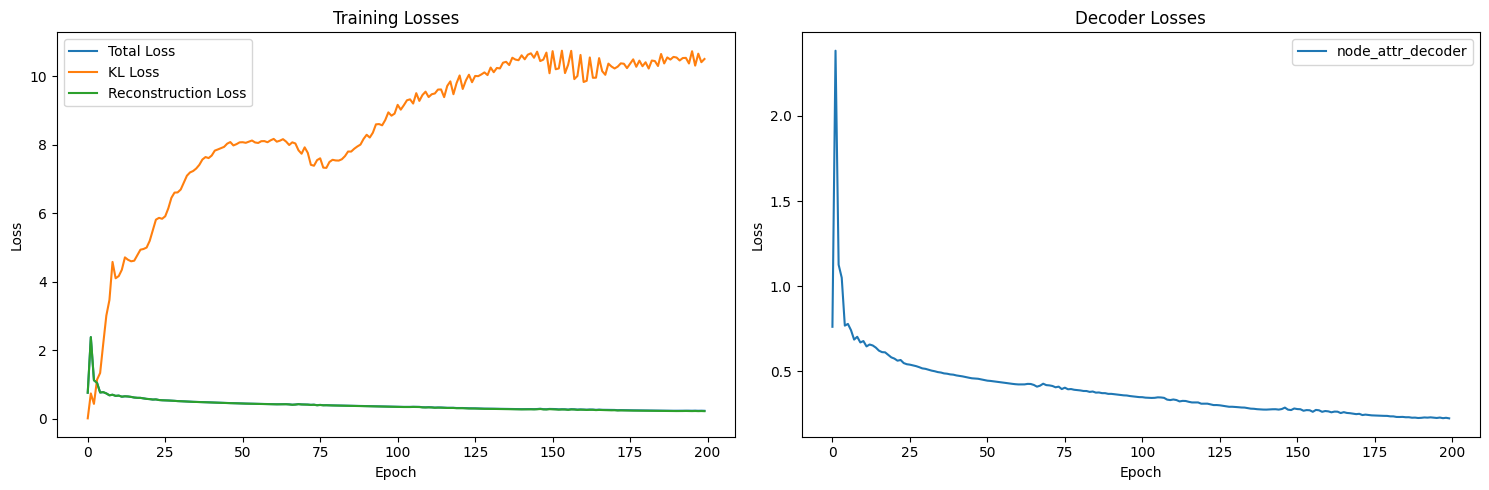

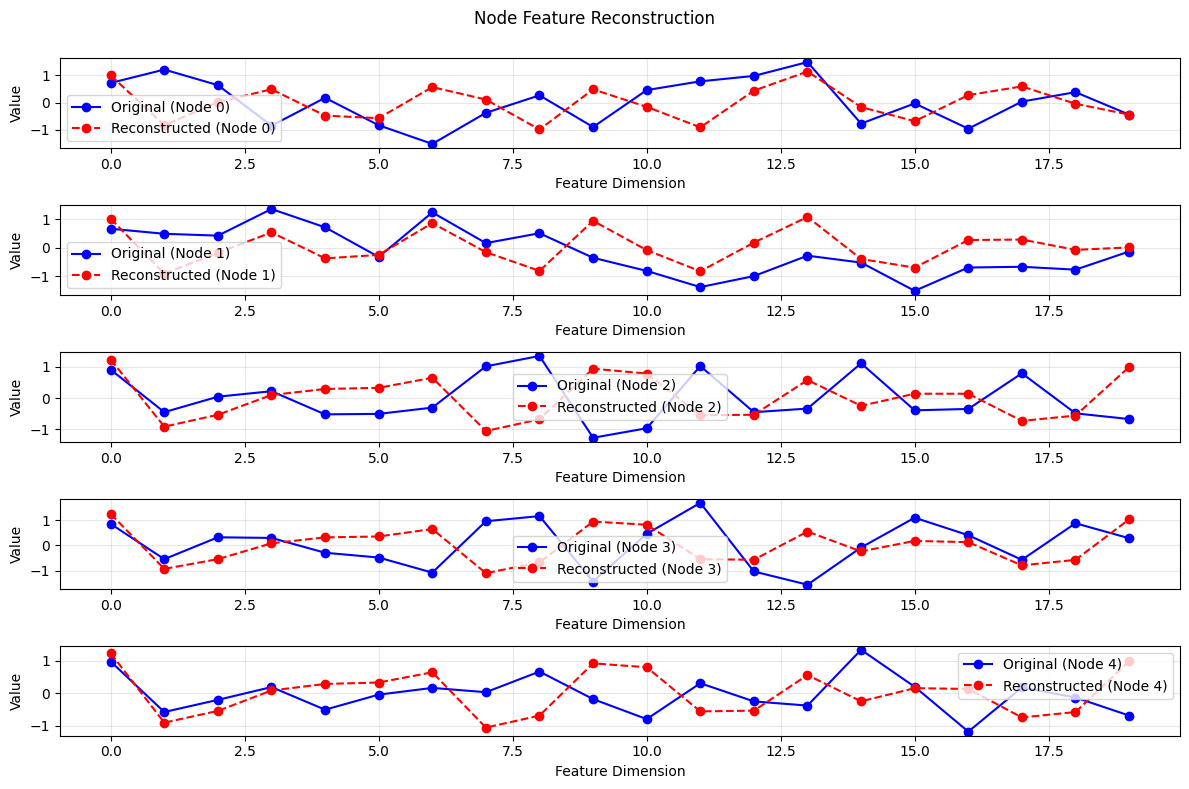

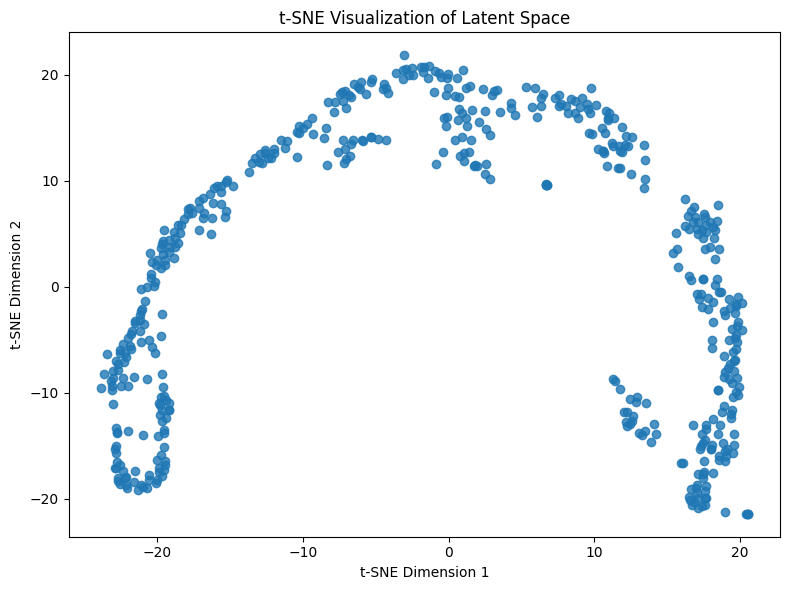

Computing metric tensors: 100%|██████████| 10000/10000 [00:04<00:00, 2006.16it/s]


Full grid metric tensor computation complete.


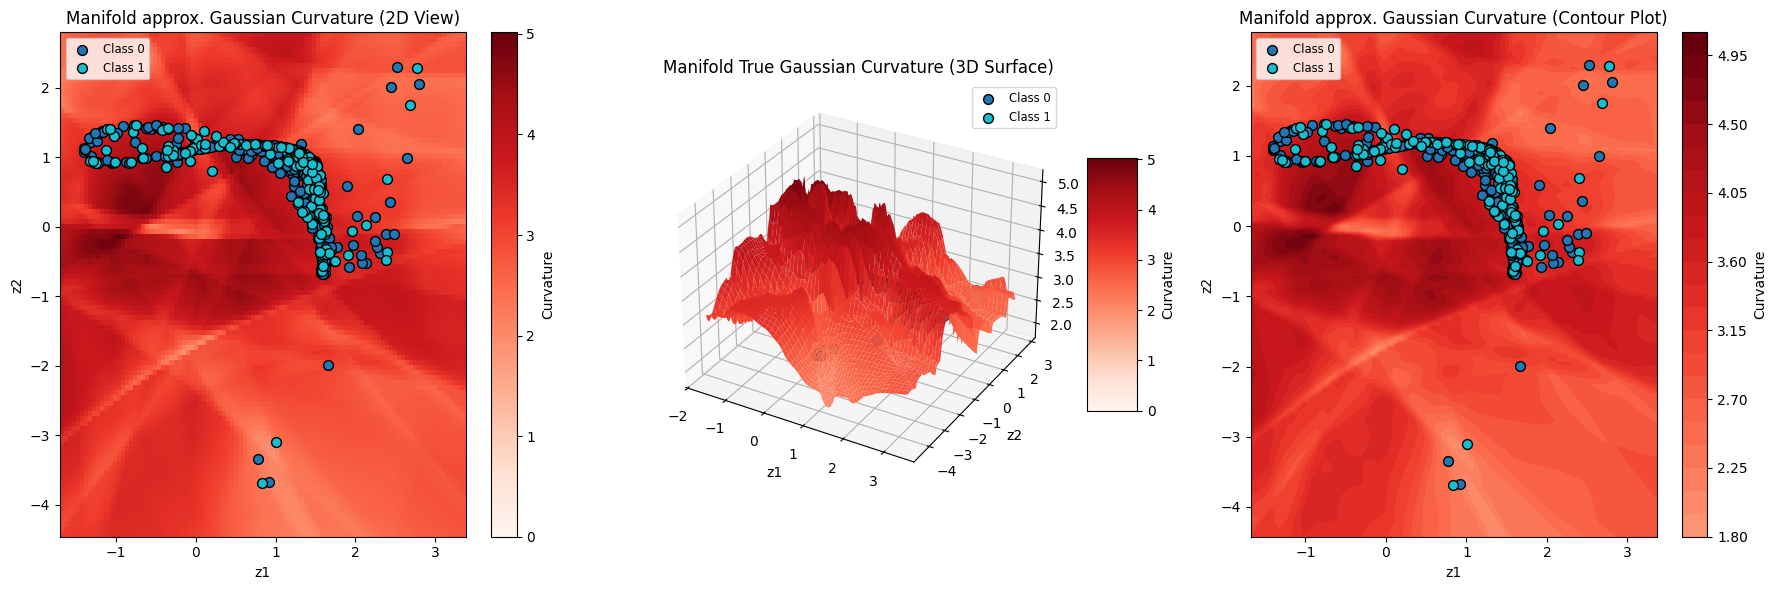

In [3]:
dropout = 0
phase1_epochs = 200
phase2_epochs = 50
lr_phase1 = 0.001
lr_phase2 = 0.05
latent_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Run two-phase training
# model, history = two_phase_training(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     data_loader_phase1=single_graph_list,
#     data_loader_phase2=single_graph_list,
#     phase1_epochs=100,
#     phase2_epochs=100,
#     verbose=True
# )

# Step 1: Create encoder and node decoder for phase 1
encoder = Encoder(
    input_dim=input_dim,
    hidden_dims=[6168, 4112, 2056, 1028, 128],
    latent_dim=latent_dim,
    gcn_layers=4,
    fc_layers=2,
    dropout=dropout,
    activation=nn.ELU()
)
# encoder = MLPEncoder(
#     input_dim=input_dim,
#     latent_dim=latent_dim,
#     hidden_dims=[5000, 1280,640, 320],
#     mlp_layers=3,
#     dropout=dropout
# )

node_decoder = NodeAttributeDecoder(
    latent_dim=latent_dim,
    output_dim=input_dim,
    hidden_dims=[5000, 128],
    #hidden_dims=[128],
    dropout=dropout,
    activation=nn.ELU(),
    #final_activation=SigmoidBinary(threshold=0.5, temperature=0.1)
)

# Create KL annealing scheduler
kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=0.001,
    anneal_steps=phase1_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Create initial model with only node decoder
model_phase1 = GraphVAE(
    encoder=encoder,
    decoders=[node_decoder],
    kl_scheduler=kl_scheduler
)

print("=== Starting Phase 1: Training encoder with node feature reconstruction ===")

# Phase 1 training
history_phase1 = train_phase1(
    model=model_phase1,
    data_loader=single_graph_list,
    num_epochs=phase1_epochs,
    lr=lr_phase1,
    weight_decay=1e-5,
    verbose=False,
    device=device,
    loss_coefficient=1
)

print("\n=== Phase 1 Complete ===")

visualize_training(history_phase1)
#visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase1, single_graph, sample_features=dimP)
visualize_latent_space(model_phase1, [single_graph])
#plot_curvature(model_phase1, single_graph)

model_phase1.eval()

with torch.no_grad():
    x = single_graph.x.to(device)
    edge_index = single_graph.edge_index.to(device)
    latent_mu = model_phase1.encode(x, edge_index)

latent_points = latent_mu[0].detach().numpy()

bounds = np.array([
    np.array([val * 0.8 if val > 0 else val * 1.2 for val in np.min(latent_points, axis=0)]),
    np.array([val * 1.2 if val > 0 else val * 0.8 for val in np.max(latent_points, axis=0)]),
]).transpose()

def metric1(z):
    return local_decoder_point_metric(z, model_phase1)


phase1_manifold = BoundedManifold(metric1, bounds, cache=True, grid_points_per_dim=100)
phase1_manifold.compute_full_grid_metric_tensor()

_ = phase1_manifold.visualize_manifold_curvature(resolution=100,
                                                data_points=latent_points,
                                                labels=np.array([0]*350 + [1]*150))


=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===


Negative Sampling: 100%|██████████| 61642/61642 [00:28<00:00, 2128.20it/s]


Loss: pos= tensor(0.4184, grad_fn=<DivBackward0>)  neg= tensor(0.3758, grad_fn=<MulBackward0>)  ( tensor(47.3184, grad_fn=<DivBackward0>) %) total= tensor(0.7941, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2058.85it/s]


Loss: pos= tensor(0.4220, grad_fn=<DivBackward0>)  neg= tensor(0.3786, grad_fn=<MulBackward0>)  ( tensor(47.2859, grad_fn=<DivBackward0>) %) total= tensor(0.8006, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2053.59it/s]


Loss: pos= tensor(0.4193, grad_fn=<DivBackward0>)  neg= tensor(0.3796, grad_fn=<MulBackward0>)  ( tensor(47.5185, grad_fn=<DivBackward0>) %) total= tensor(0.7989, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:31<00:00, 1984.90it/s]


Loss: pos= tensor(0.4192, grad_fn=<DivBackward0>)  neg= tensor(0.3781, grad_fn=<MulBackward0>)  ( tensor(47.4182, grad_fn=<DivBackward0>) %) total= tensor(0.7973, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2063.31it/s]


Loss: pos= tensor(0.4206, grad_fn=<DivBackward0>)  neg= tensor(0.3770, grad_fn=<MulBackward0>)  ( tensor(47.2632, grad_fn=<DivBackward0>) %) total= tensor(0.7976, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2049.85it/s]


Loss: pos= tensor(0.4202, grad_fn=<DivBackward0>)  neg= tensor(0.3761, grad_fn=<MulBackward0>)  ( tensor(47.2302, grad_fn=<DivBackward0>) %) total= tensor(0.7963, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2080.63it/s]


Loss: pos= tensor(0.4203, grad_fn=<DivBackward0>)  neg= tensor(0.3772, grad_fn=<MulBackward0>)  ( tensor(47.2980, grad_fn=<DivBackward0>) %) total= tensor(0.7975, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2027.42it/s]


Loss: pos= tensor(0.4225, grad_fn=<DivBackward0>)  neg= tensor(0.3777, grad_fn=<MulBackward0>)  ( tensor(47.1995, grad_fn=<DivBackward0>) %) total= tensor(0.8002, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2074.02it/s]


Loss: pos= tensor(0.4195, grad_fn=<DivBackward0>)  neg= tensor(0.3751, grad_fn=<MulBackward0>)  ( tensor(47.2014, grad_fn=<DivBackward0>) %) total= tensor(0.7946, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2072.97it/s]


Loss: pos= tensor(0.4192, grad_fn=<DivBackward0>)  neg= tensor(0.3776, grad_fn=<MulBackward0>)  ( tensor(47.3886, grad_fn=<DivBackward0>) %) total= tensor(0.7968, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2093.86it/s]


Loss: pos= tensor(0.4176, grad_fn=<DivBackward0>)  neg= tensor(0.3779, grad_fn=<MulBackward0>)  ( tensor(47.5047, grad_fn=<DivBackward0>) %) total= tensor(0.7956, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:28<00:00, 2131.36it/s]


Loss: pos= tensor(0.4209, grad_fn=<DivBackward0>)  neg= tensor(0.3765, grad_fn=<MulBackward0>)  ( tensor(47.2181, grad_fn=<DivBackward0>) %) total= tensor(0.7974, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:28<00:00, 2125.73it/s]


Loss: pos= tensor(0.4189, grad_fn=<DivBackward0>)  neg= tensor(0.3796, grad_fn=<MulBackward0>)  ( tensor(47.5361, grad_fn=<DivBackward0>) %) total= tensor(0.7985, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2074.69it/s]


Loss: pos= tensor(0.4207, grad_fn=<DivBackward0>)  neg= tensor(0.3773, grad_fn=<MulBackward0>)  ( tensor(47.2813, grad_fn=<DivBackward0>) %) total= tensor(0.7980, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2064.14it/s]


Loss: pos= tensor(0.4170, grad_fn=<DivBackward0>)  neg= tensor(0.3802, grad_fn=<MulBackward0>)  ( tensor(47.6946, grad_fn=<DivBackward0>) %) total= tensor(0.7972, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2051.45it/s]


Loss: pos= tensor(0.4185, grad_fn=<DivBackward0>)  neg= tensor(0.3793, grad_fn=<MulBackward0>)  ( tensor(47.5438, grad_fn=<DivBackward0>) %) total= tensor(0.7979, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2064.24it/s]


Loss: pos= tensor(0.4189, grad_fn=<DivBackward0>)  neg= tensor(0.3775, grad_fn=<MulBackward0>)  ( tensor(47.3995, grad_fn=<DivBackward0>) %) total= tensor(0.7964, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2039.78it/s]


Loss: pos= tensor(0.4204, grad_fn=<DivBackward0>)  neg= tensor(0.3782, grad_fn=<MulBackward0>)  ( tensor(47.3547, grad_fn=<DivBackward0>) %) total= tensor(0.7986, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2069.78it/s]


Loss: pos= tensor(0.4174, grad_fn=<DivBackward0>)  neg= tensor(0.3773, grad_fn=<MulBackward0>)  ( tensor(47.4786, grad_fn=<DivBackward0>) %) total= tensor(0.7948, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2048.40it/s]


Loss: pos= tensor(0.4210, grad_fn=<DivBackward0>)  neg= tensor(0.3766, grad_fn=<MulBackward0>)  ( tensor(47.2195, grad_fn=<DivBackward0>) %) total= tensor(0.7976, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2046.47it/s]


Loss: pos= tensor(0.4205, grad_fn=<DivBackward0>)  neg= tensor(0.3772, grad_fn=<MulBackward0>)  ( tensor(47.2888, grad_fn=<DivBackward0>) %) total= tensor(0.7977, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2082.03it/s]


Loss: pos= tensor(0.4181, grad_fn=<DivBackward0>)  neg= tensor(0.3785, grad_fn=<MulBackward0>)  ( tensor(47.5177, grad_fn=<DivBackward0>) %) total= tensor(0.7966, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2041.49it/s]


Loss: pos= tensor(0.4177, grad_fn=<DivBackward0>)  neg= tensor(0.3762, grad_fn=<MulBackward0>)  ( tensor(47.3856, grad_fn=<DivBackward0>) %) total= tensor(0.7940, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2023.78it/s]


Loss: pos= tensor(0.4183, grad_fn=<DivBackward0>)  neg= tensor(0.3775, grad_fn=<MulBackward0>)  ( tensor(47.4395, grad_fn=<DivBackward0>) %) total= tensor(0.7958, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2033.89it/s]


Loss: pos= tensor(0.4205, grad_fn=<DivBackward0>)  neg= tensor(0.3780, grad_fn=<MulBackward0>)  ( tensor(47.3381, grad_fn=<DivBackward0>) %) total= tensor(0.7985, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2062.68it/s]


Loss: pos= tensor(0.4188, grad_fn=<DivBackward0>)  neg= tensor(0.3791, grad_fn=<MulBackward0>)  ( tensor(47.5112, grad_fn=<DivBackward0>) %) total= tensor(0.7979, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2078.35it/s]


Loss: pos= tensor(0.4193, grad_fn=<DivBackward0>)  neg= tensor(0.3785, grad_fn=<MulBackward0>)  ( tensor(47.4418, grad_fn=<DivBackward0>) %) total= tensor(0.7978, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2062.60it/s]


Loss: pos= tensor(0.4184, grad_fn=<DivBackward0>)  neg= tensor(0.3791, grad_fn=<MulBackward0>)  ( tensor(47.5383, grad_fn=<DivBackward0>) %) total= tensor(0.7974, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2107.71it/s]


Loss: pos= tensor(0.4183, grad_fn=<DivBackward0>)  neg= tensor(0.3784, grad_fn=<MulBackward0>)  ( tensor(47.4972, grad_fn=<DivBackward0>) %) total= tensor(0.7966, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2102.80it/s]


Loss: pos= tensor(0.4183, grad_fn=<DivBackward0>)  neg= tensor(0.3791, grad_fn=<MulBackward0>)  ( tensor(47.5425, grad_fn=<DivBackward0>) %) total= tensor(0.7974, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2038.84it/s]


Loss: pos= tensor(0.4169, grad_fn=<DivBackward0>)  neg= tensor(0.3763, grad_fn=<MulBackward0>)  ( tensor(47.4408, grad_fn=<DivBackward0>) %) total= tensor(0.7932, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2085.15it/s]


Loss: pos= tensor(0.4197, grad_fn=<DivBackward0>)  neg= tensor(0.3782, grad_fn=<MulBackward0>)  ( tensor(47.3944, grad_fn=<DivBackward0>) %) total= tensor(0.7979, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2100.20it/s]


Loss: pos= tensor(0.4182, grad_fn=<DivBackward0>)  neg= tensor(0.3798, grad_fn=<MulBackward0>)  ( tensor(47.5913, grad_fn=<DivBackward0>) %) total= tensor(0.7980, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2072.26it/s]


Loss: pos= tensor(0.4176, grad_fn=<DivBackward0>)  neg= tensor(0.3771, grad_fn=<MulBackward0>)  ( tensor(47.4524, grad_fn=<DivBackward0>) %) total= tensor(0.7946, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2101.94it/s]


Loss: pos= tensor(0.4194, grad_fn=<DivBackward0>)  neg= tensor(0.3773, grad_fn=<MulBackward0>)  ( tensor(47.3616, grad_fn=<DivBackward0>) %) total= tensor(0.7967, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2072.22it/s]


Loss: pos= tensor(0.4177, grad_fn=<DivBackward0>)  neg= tensor(0.3775, grad_fn=<MulBackward0>)  ( tensor(47.4694, grad_fn=<DivBackward0>) %) total= tensor(0.7952, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2059.08it/s]


Loss: pos= tensor(0.4178, grad_fn=<DivBackward0>)  neg= tensor(0.3767, grad_fn=<MulBackward0>)  ( tensor(47.4180, grad_fn=<DivBackward0>) %) total= tensor(0.7945, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2060.36it/s]


Loss: pos= tensor(0.4197, grad_fn=<DivBackward0>)  neg= tensor(0.3772, grad_fn=<MulBackward0>)  ( tensor(47.3300, grad_fn=<DivBackward0>) %) total= tensor(0.7969, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2084.58it/s]


Loss: pos= tensor(0.4184, grad_fn=<DivBackward0>)  neg= tensor(0.3780, grad_fn=<MulBackward0>)  ( tensor(47.4618, grad_fn=<DivBackward0>) %) total= tensor(0.7964, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2032.04it/s]


Loss: pos= tensor(0.4214, grad_fn=<DivBackward0>)  neg= tensor(0.3770, grad_fn=<MulBackward0>)  ( tensor(47.2188, grad_fn=<DivBackward0>) %) total= tensor(0.7983, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2073.65it/s]


Loss: pos= tensor(0.4191, grad_fn=<DivBackward0>)  neg= tensor(0.3759, grad_fn=<MulBackward0>)  ( tensor(47.2814, grad_fn=<DivBackward0>) %) total= tensor(0.7950, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2029.04it/s]


Loss: pos= tensor(0.4197, grad_fn=<DivBackward0>)  neg= tensor(0.3800, grad_fn=<MulBackward0>)  ( tensor(47.5208, grad_fn=<DivBackward0>) %) total= tensor(0.7997, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2069.62it/s]


Loss: pos= tensor(0.4181, grad_fn=<DivBackward0>)  neg= tensor(0.3781, grad_fn=<MulBackward0>)  ( tensor(47.4862, grad_fn=<DivBackward0>) %) total= tensor(0.7962, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2082.04it/s]


Loss: pos= tensor(0.4187, grad_fn=<DivBackward0>)  neg= tensor(0.3772, grad_fn=<MulBackward0>)  ( tensor(47.3929, grad_fn=<DivBackward0>) %) total= tensor(0.7958, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2062.90it/s]


Loss: pos= tensor(0.4194, grad_fn=<DivBackward0>)  neg= tensor(0.3783, grad_fn=<MulBackward0>)  ( tensor(47.4210, grad_fn=<DivBackward0>) %) total= tensor(0.7977, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2054.05it/s]


Loss: pos= tensor(0.4196, grad_fn=<DivBackward0>)  neg= tensor(0.3774, grad_fn=<MulBackward0>)  ( tensor(47.3535, grad_fn=<DivBackward0>) %) total= tensor(0.7970, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2067.48it/s]


Loss: pos= tensor(0.4212, grad_fn=<DivBackward0>)  neg= tensor(0.3771, grad_fn=<MulBackward0>)  ( tensor(47.2401, grad_fn=<DivBackward0>) %) total= tensor(0.7983, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2041.05it/s]


Loss: pos= tensor(0.4193, grad_fn=<DivBackward0>)  neg= tensor(0.3757, grad_fn=<MulBackward0>)  ( tensor(47.2537, grad_fn=<DivBackward0>) %) total= tensor(0.7950, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:29<00:00, 2096.17it/s]


Loss: pos= tensor(0.4179, grad_fn=<DivBackward0>)  neg= tensor(0.3780, grad_fn=<MulBackward0>)  ( tensor(47.4916, grad_fn=<DivBackward0>) %) total= tensor(0.7959, grad_fn=<AddBackward0>)


Negative Sampling: 100%|██████████| 61642/61642 [00:30<00:00, 2042.94it/s]


Loss: pos= tensor(0.4182, grad_fn=<DivBackward0>)  neg= tensor(0.3792, grad_fn=<MulBackward0>)  ( tensor(47.5565, grad_fn=<DivBackward0>) %) total= tensor(0.7974, grad_fn=<AddBackward0>)

=== Phase 2 Complete ===


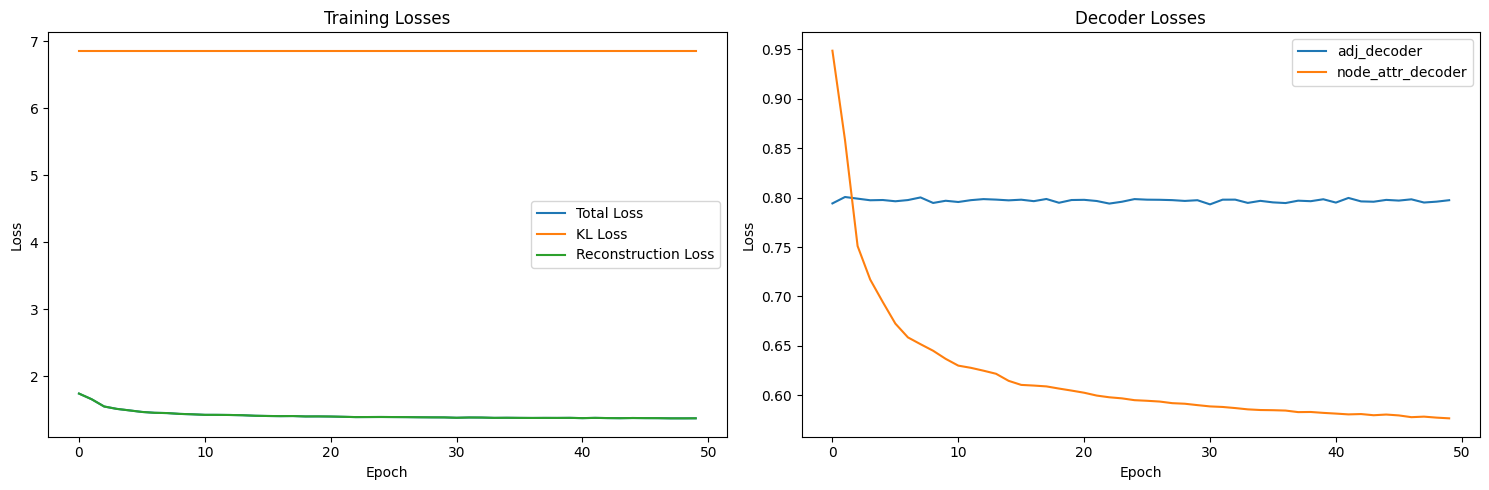

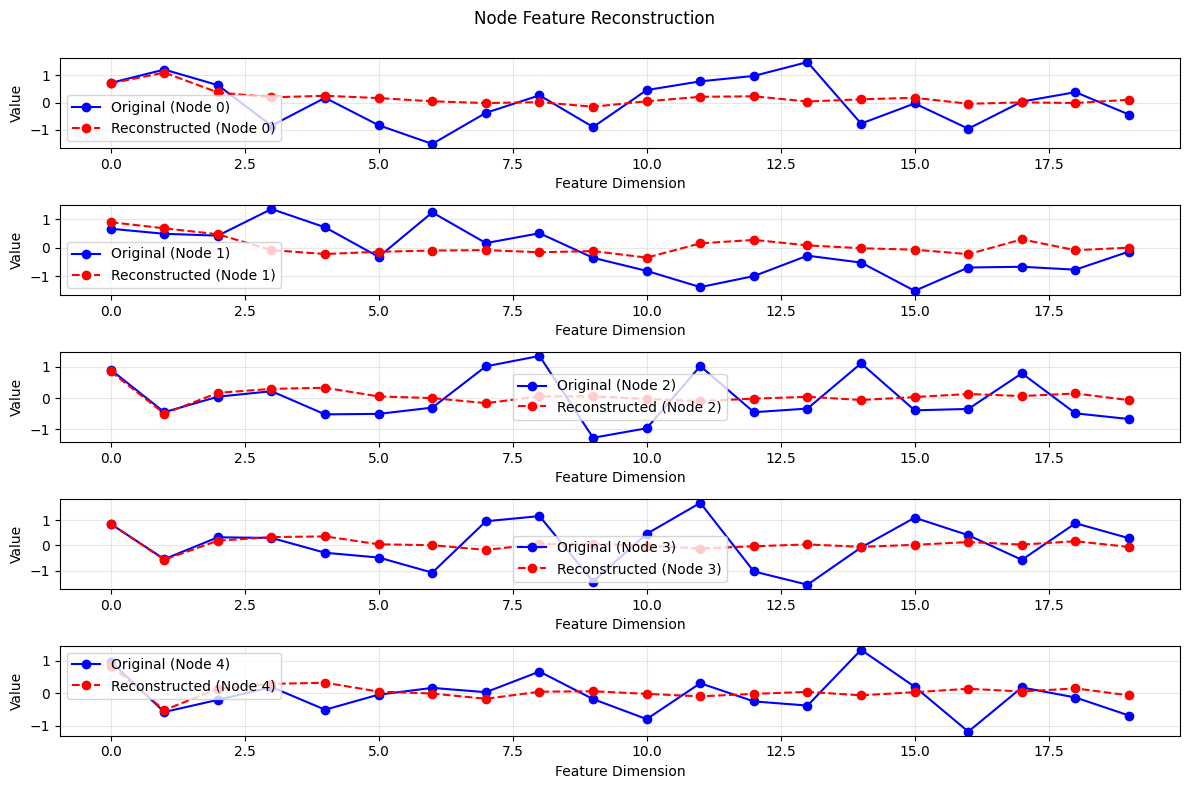

In [4]:
import copy

lr_phase2 = 0.001

print("=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===")

model_phase2 = copy.deepcopy(model_phase1)

distance_decoder = LatentDistanceDecoder(
   latent_dim=latent_dim,
   reference_decoder_name="node_attr_decoder",
   distance_mode="linear_interpolation",  # or "direct"
   name="adj_decoder",
   num_integration_points=10
)

# Set reference decoder (the node attribute decoder)
distance_decoder.set_reference_decoder(node_decoder)

# distance_decoder = LatentDistanceDecoder(
#     latent_dim=latent_dim,
#     reference_decoder=node_decoder,
#     grid_size=32, z_min=-2.0, z_max=2.0, 
#     metric_regularization=1e-5)

# Add to your GraphVAE model
model_phase2.add_decoder(distance_decoder)

# Reset KL scheduler for phase 2
model_phase2.kl_scheduler = KLAnnealingScheduler(
    anneal_start=0,  # Start at midpoint since encoder is already trained
    anneal_end=0,
    anneal_steps=phase2_epochs * len(single_graph_list),
    anneal_type='linear'
)

# Phase 2 training
history_phase2 = train_phase2(
    model=model_phase2,
    data_loader=single_graph_list,
    num_epochs=phase2_epochs,
    lr=lr_phase2,
    weight_decay=1e-5,
    decoder_weights={"adj_decoder": 1, "node_decoder":0.000001 },
    verbose=False,
    device=device,
)

print("\n=== Phase 2 Complete ===")
visualize_training(history_phase2)
#visualize_graph_reconstruction(model_phase1, single_graph)
visualize_node_features_reconstruction(model_phase2, single_graph, sample_features=dimP)
#visualize_latent_space(model_phase1, [single_graph])
#plot_curvature(model_phase1, single_graph)


# Combine histories
combined_history = {
    "phase1": history_phase1,
    "phase2": history_phase2
}

# Unfreeze encoder for potential further use
model_phase1.set_encoder_freeze(False)

Computing metric tensors: 100%|██████████| 10000/10000 [00:05<00:00, 1922.95it/s]


Full grid metric tensor computation complete.


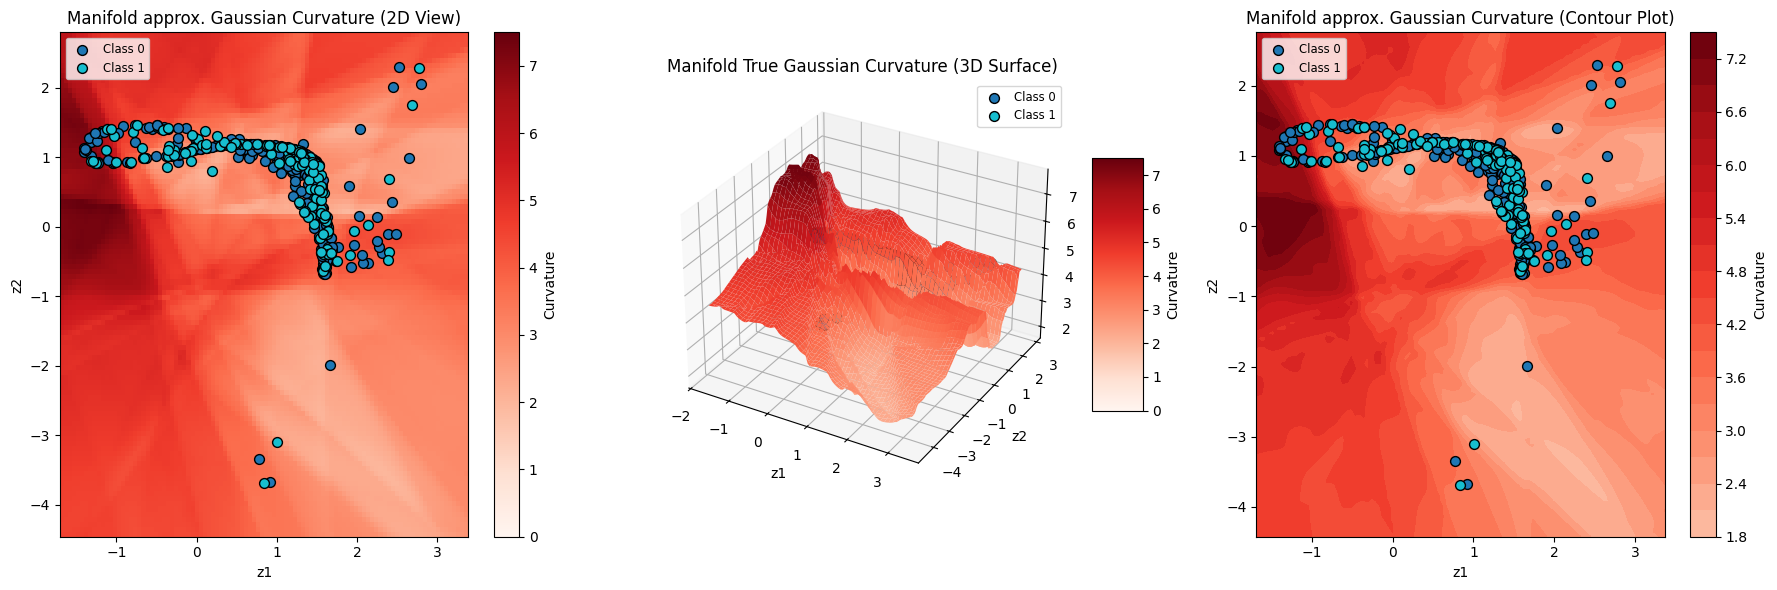

In [5]:
def metric2(z):
    return local_decoder_point_metric(z, model_phase2)

phase2_manifold = BoundedManifold(metric2, bounds, cache=True, grid_points_per_dim=100)
phase2_manifold.compute_full_grid_metric_tensor()

_ = phase2_manifold.visualize_manifold_curvature(resolution=100,
                                                data_points=latent_points,
                                                labels=np.array([0]*350 + [1]*150))

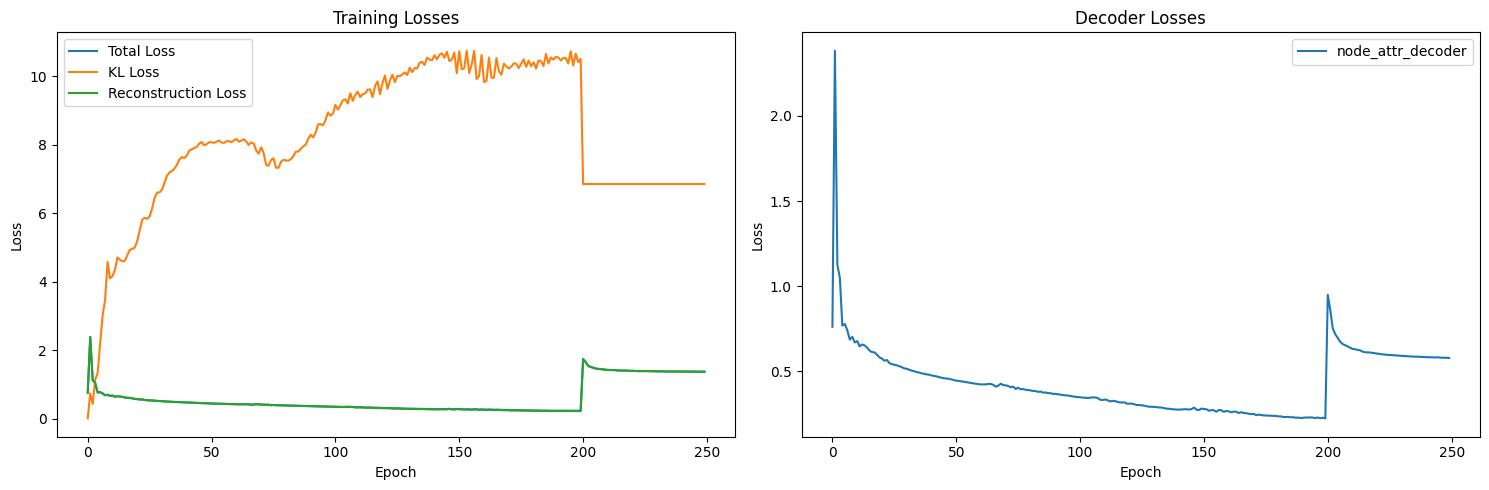

In [6]:
merged_history = {}
for key in history_phase1.keys():
  if isinstance(history_phase1[key], list):
    merged_history[key] = history_phase1[key] + history_phase2[key]
  else:
     merged_history[key] = dict()
     for key2 in history_phase1[key].keys():
        merged_history[key][key2] = history_phase1[key][key2] + history_phase2[key][key2]

visualize_training(merged_history)

Testing 45 point pairs on Phase 1 manifold...

=== Results Summary for Phase 1 Manifold ===
Method               MAE        Max AE     MRE        Max RE     RMSE       Time (ms)   
--------------------------------------------------------------------------------------------
linear_interpolation 0.7450     2.7398     0.0967     0.6516     1.0218     2.5673      
midpoint             2.1033     6.7056     0.2000     0.6509     2.9991     0.0315      
weighted_midpoint    1.3752     5.9767     0.1467     0.6520     1.9210     0.0847      
endpoint_average     1.6807     5.2512     0.1793     0.6541     2.2381     0.0520      
euclidean            5.2935     11.3792    0.5740     0.8780     6.0238     0.0041      
Generating manifold curvature visualization...


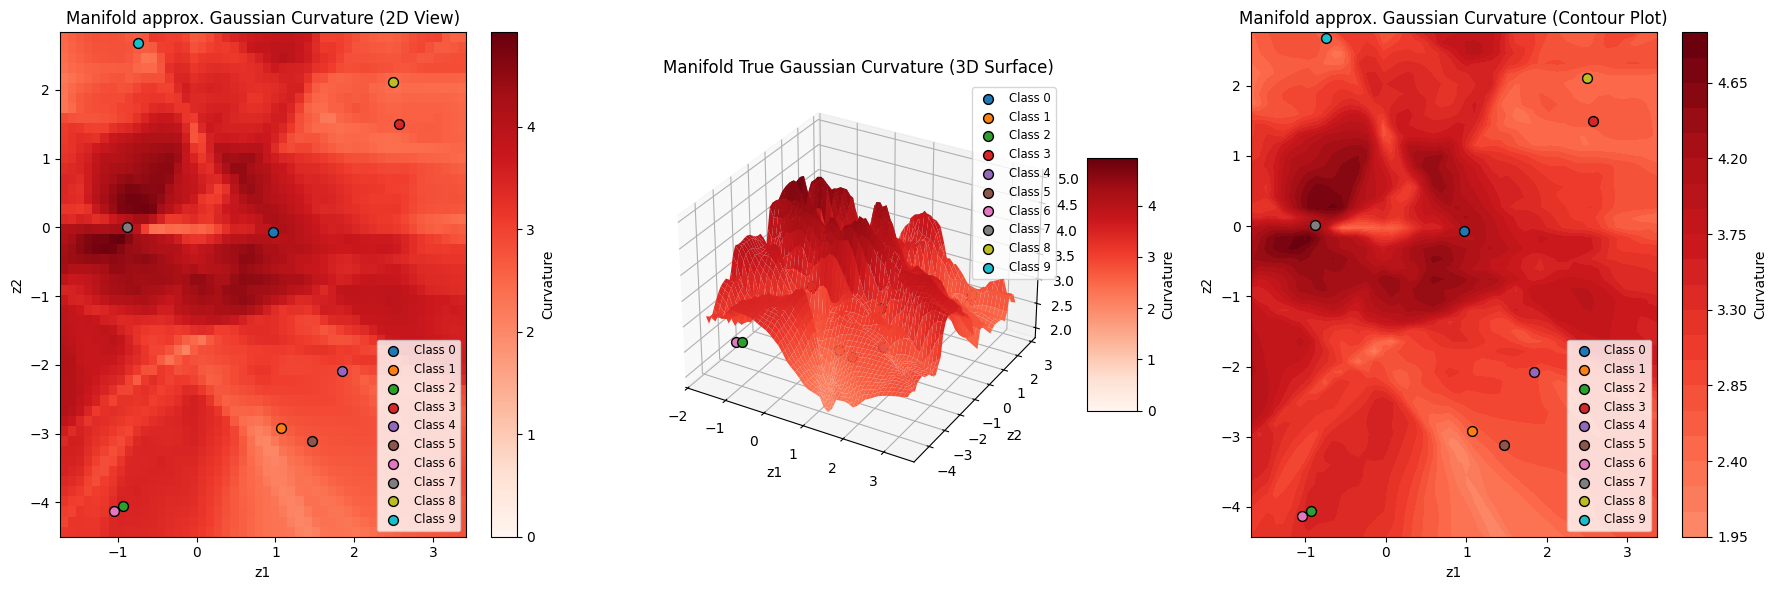

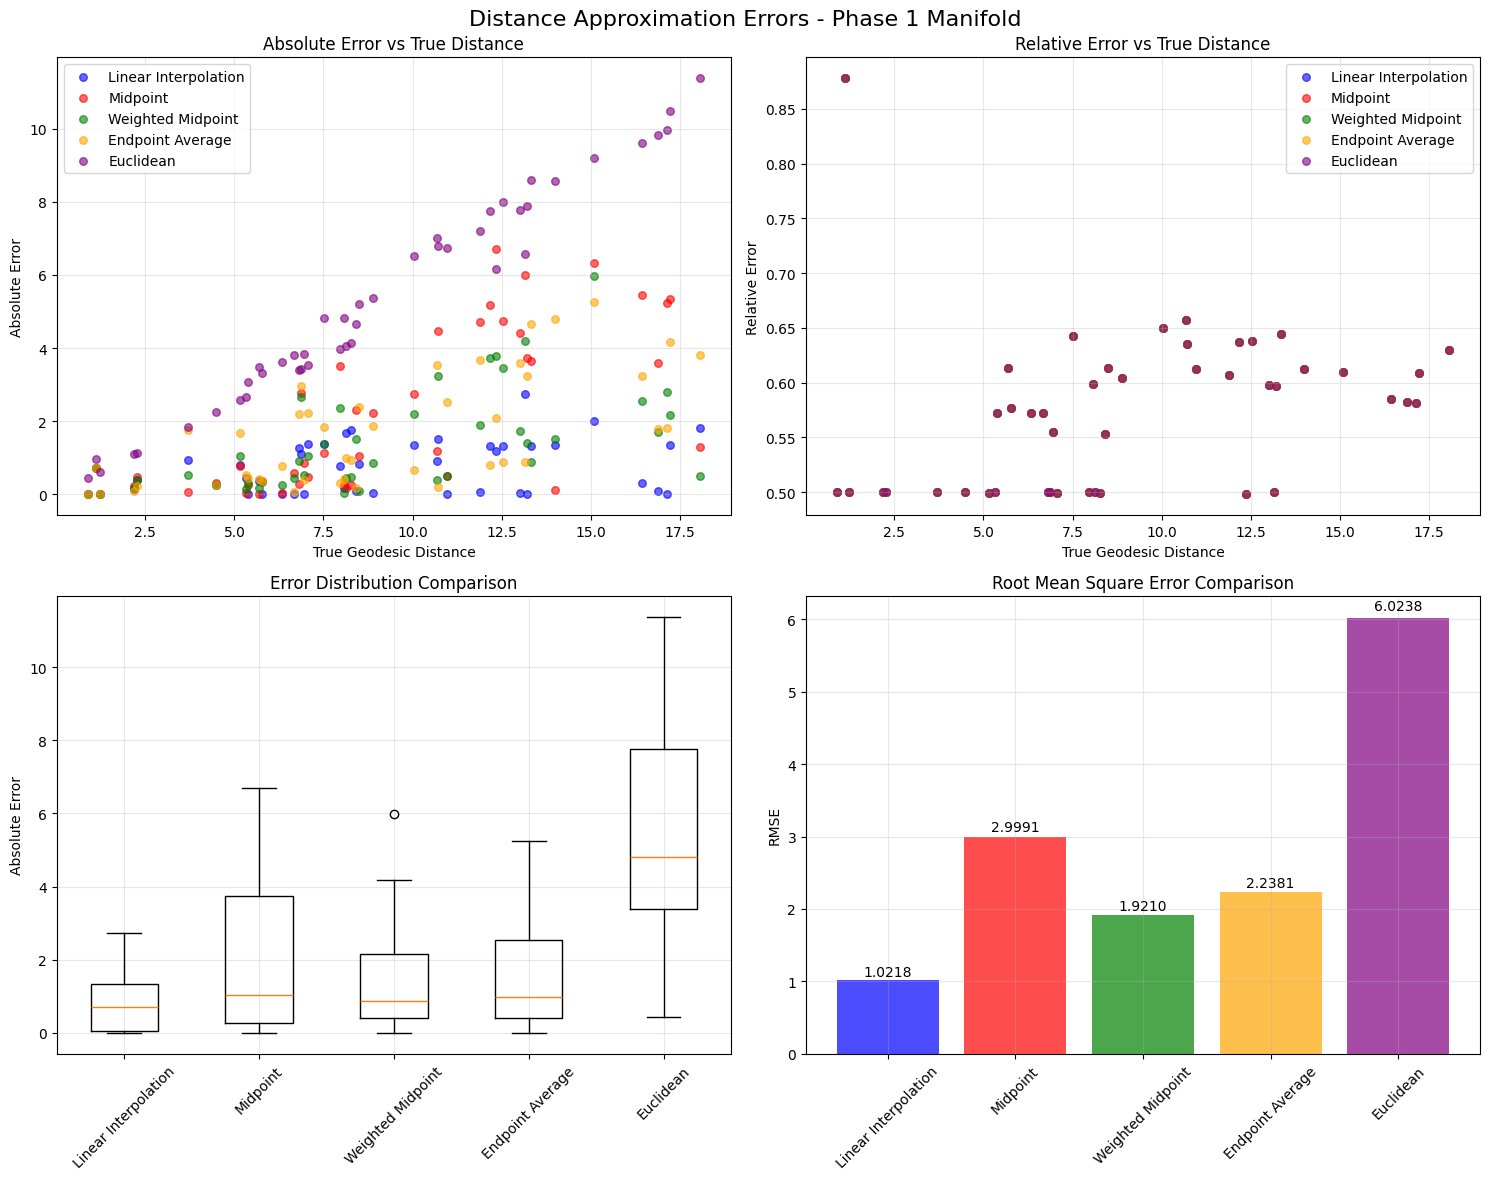

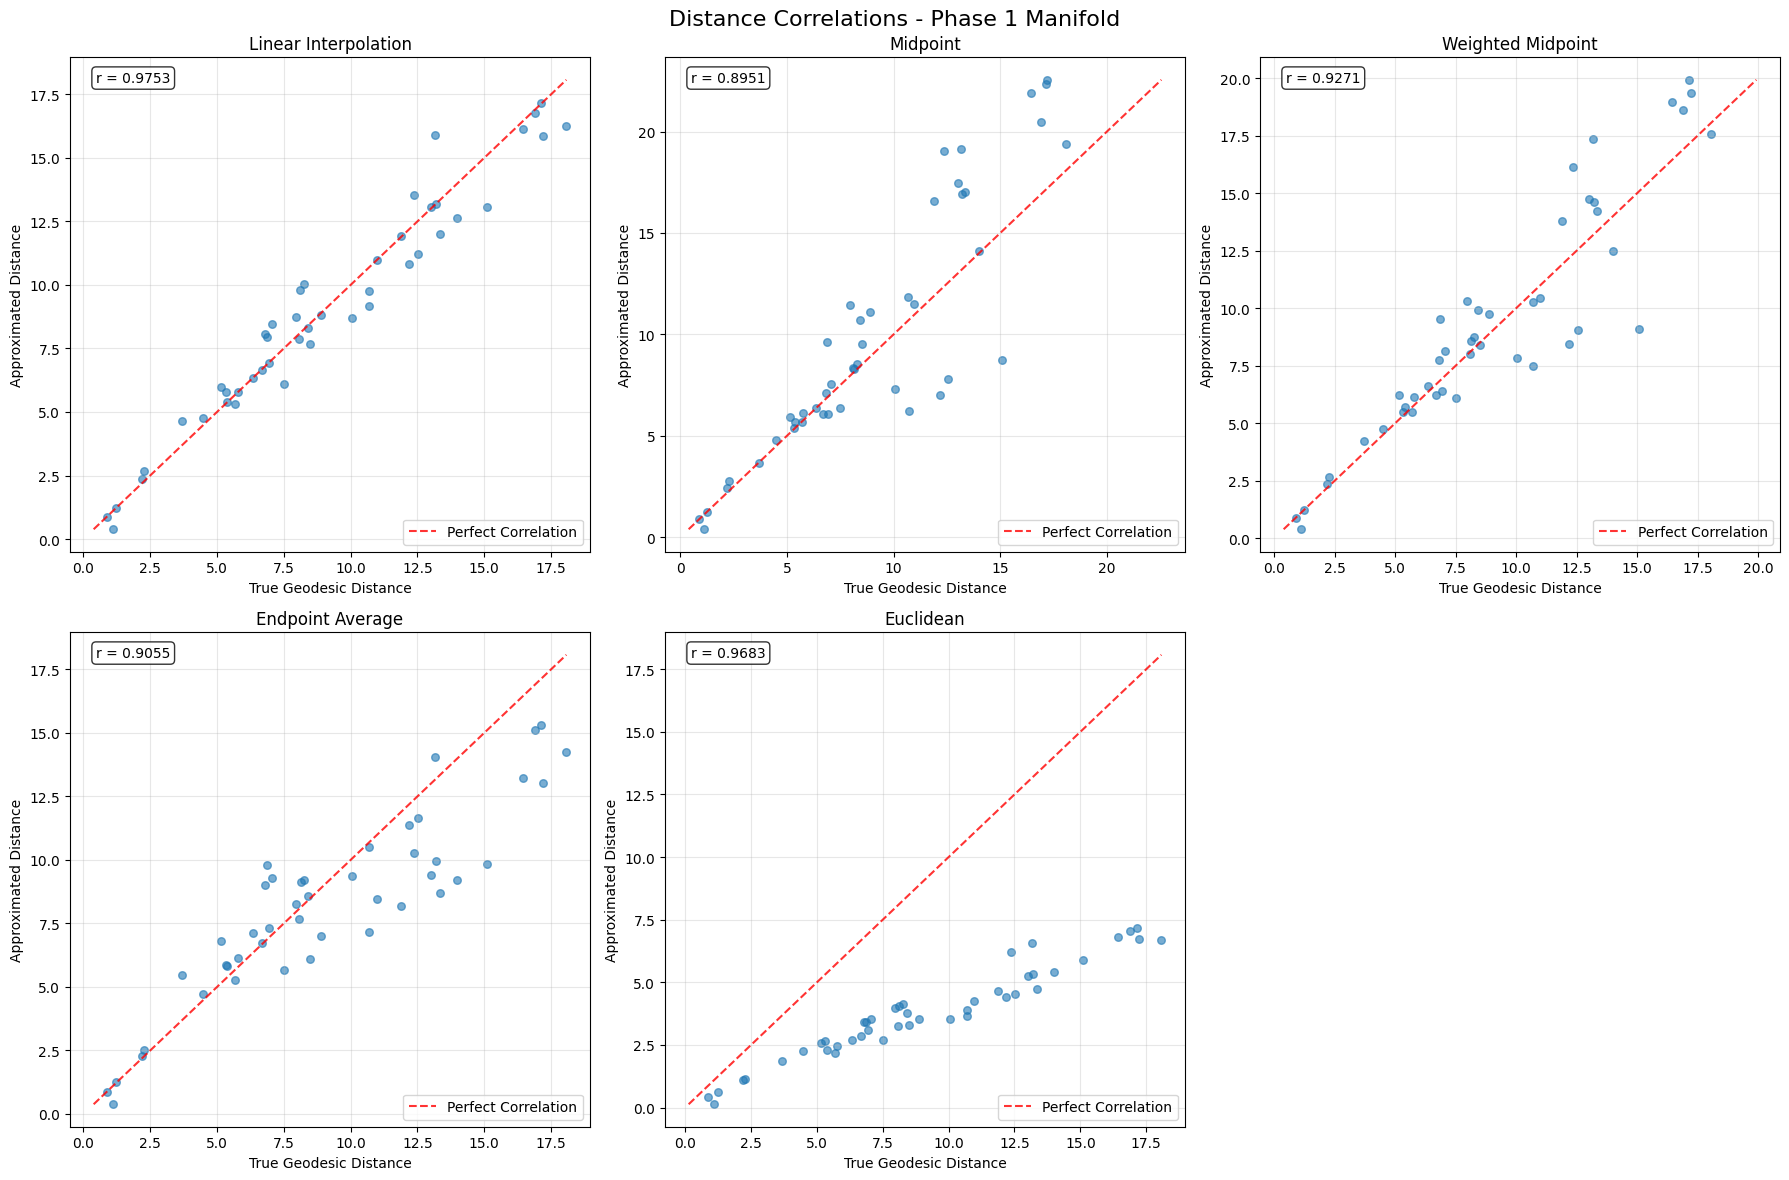

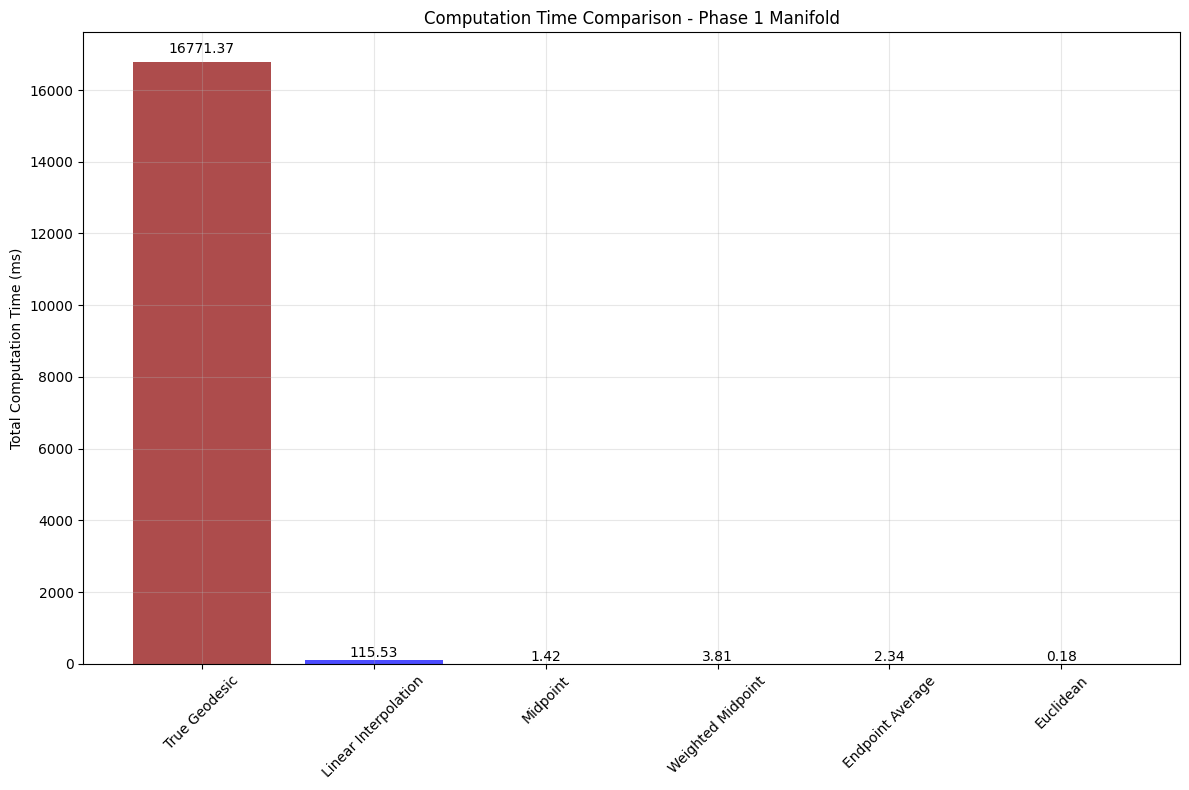

Generating example geodesic visualization...


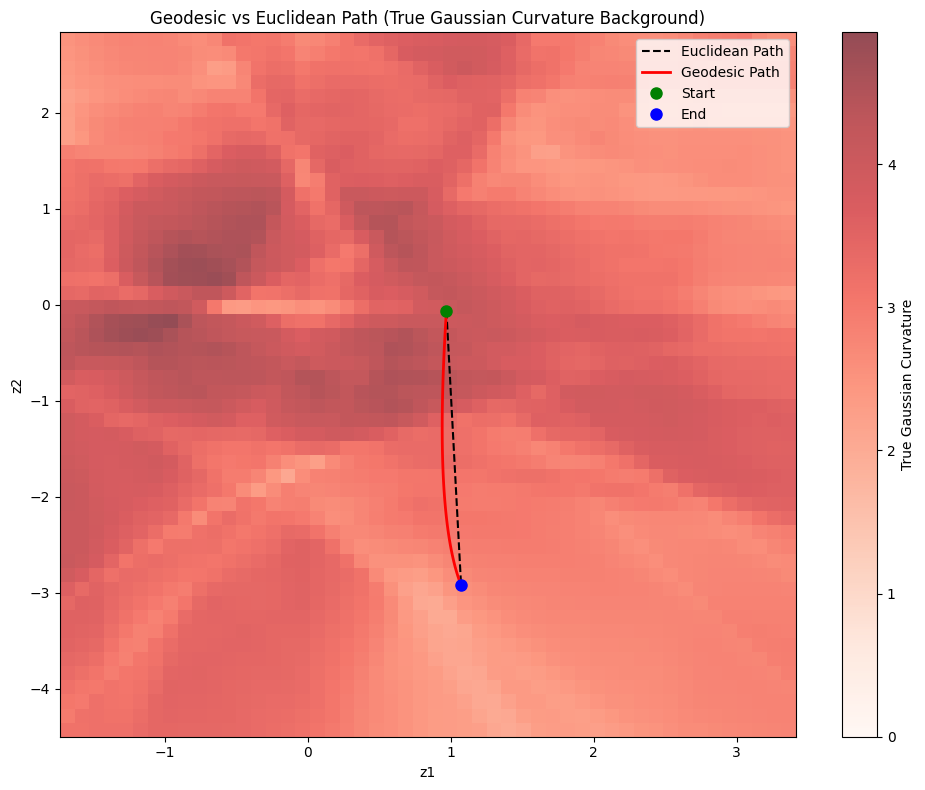

Testing 45 point pairs on Phase 2 manifold...

=== Results Summary for Phase 2 Manifold ===
Method               MAE        Max AE     MRE        Max RE     RMSE       Time (ms)   
--------------------------------------------------------------------------------------------
linear_interpolation 0.8669     4.0766     0.1166     0.6373     1.3717     2.6631      
midpoint             2.6925     10.7611    0.2471     0.7339     3.7924     0.0320      
weighted_midpoint    2.0480     8.4297     0.2093     0.6372     2.7520     0.0841      
endpoint_average     2.2635     13.3428    0.2852     1.7800     3.5292     0.0550      
euclidean            6.8658     15.5778    0.6264     0.9277     7.9778     0.0043      
Generating manifold curvature visualization...


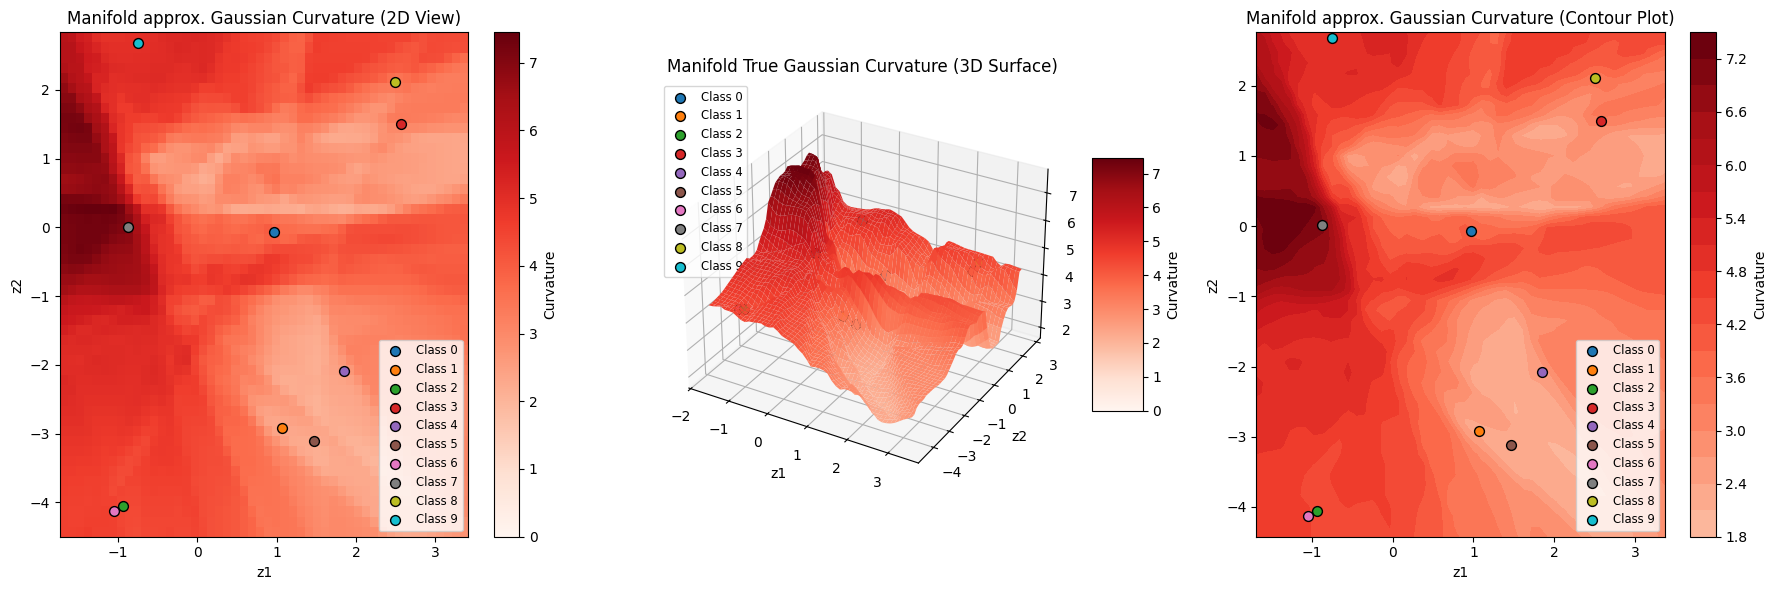

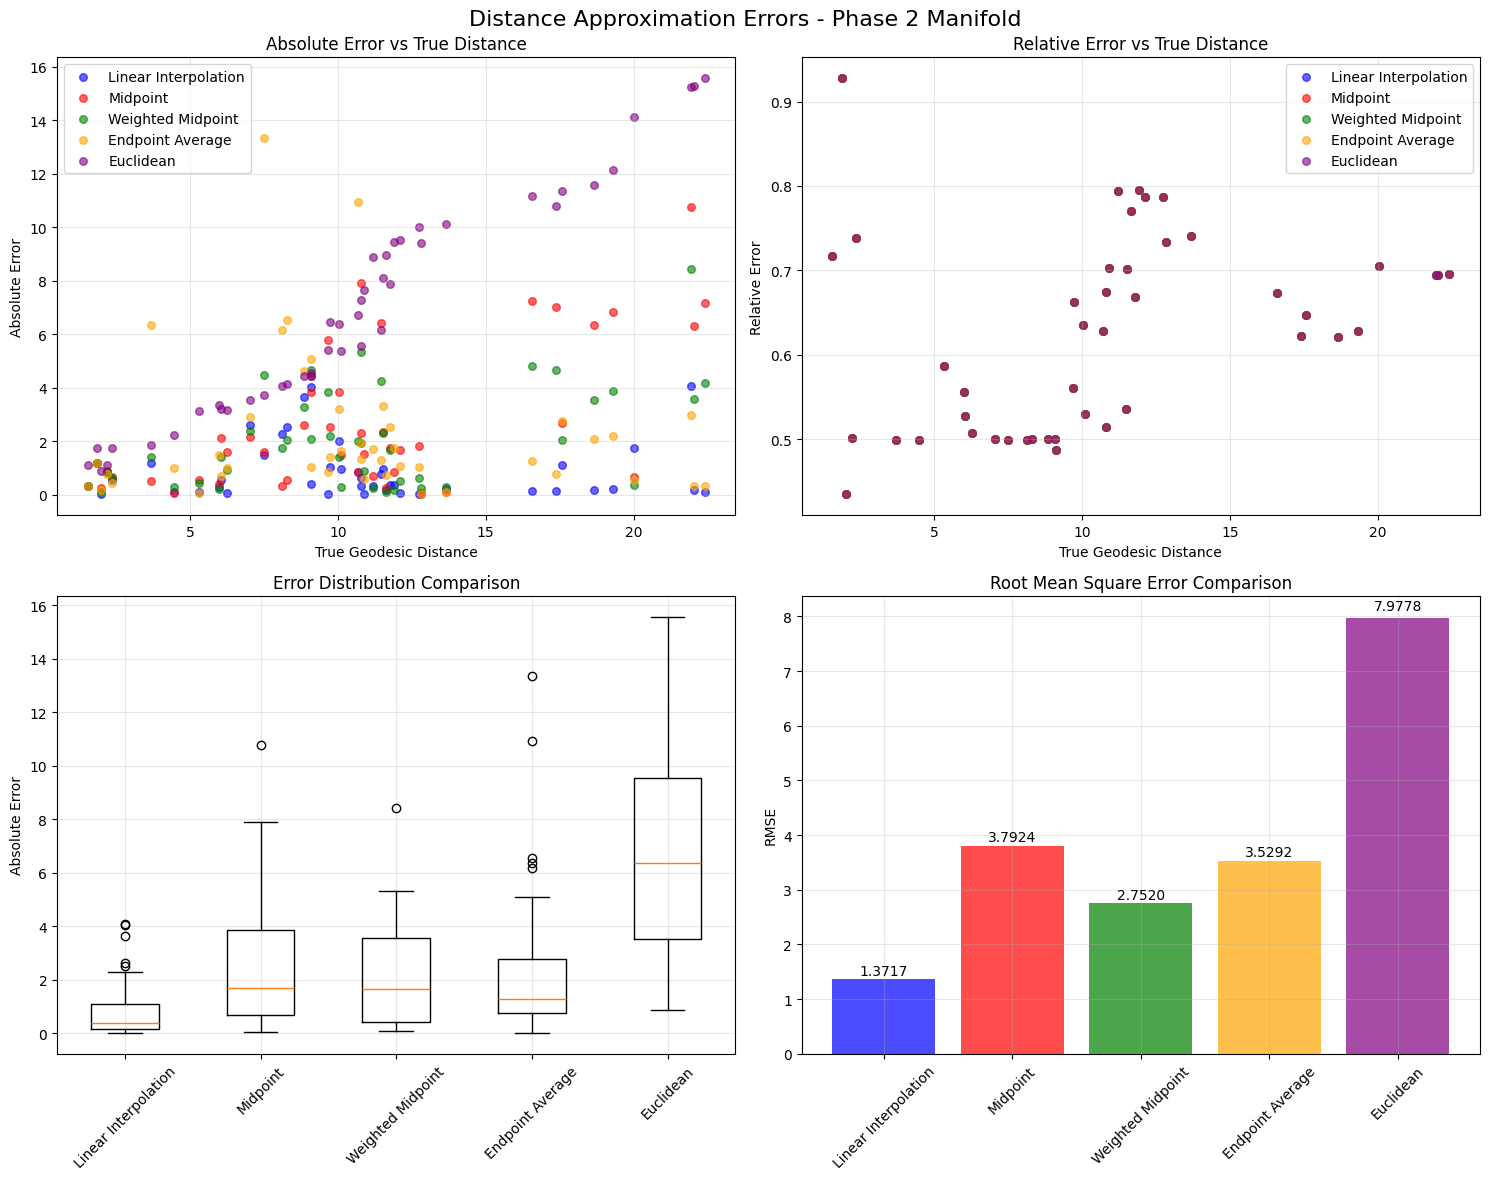

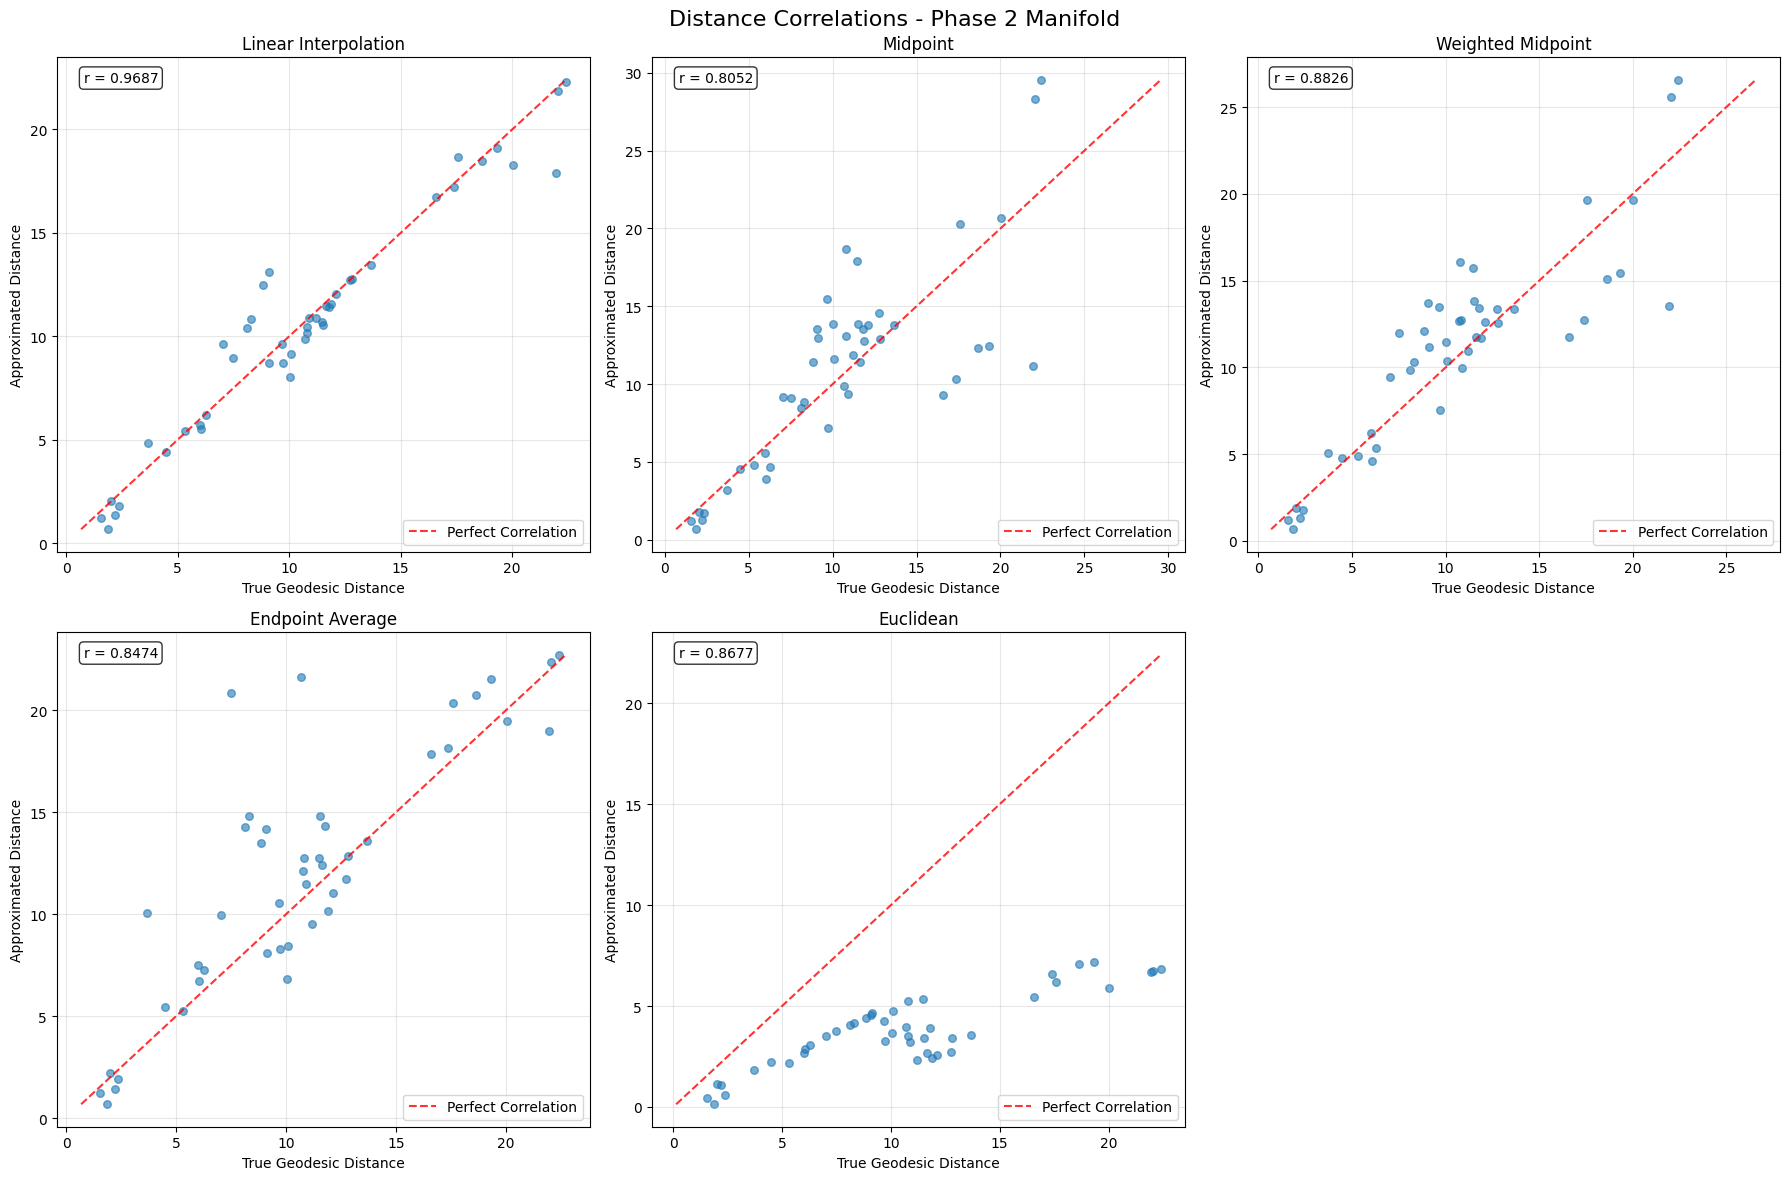

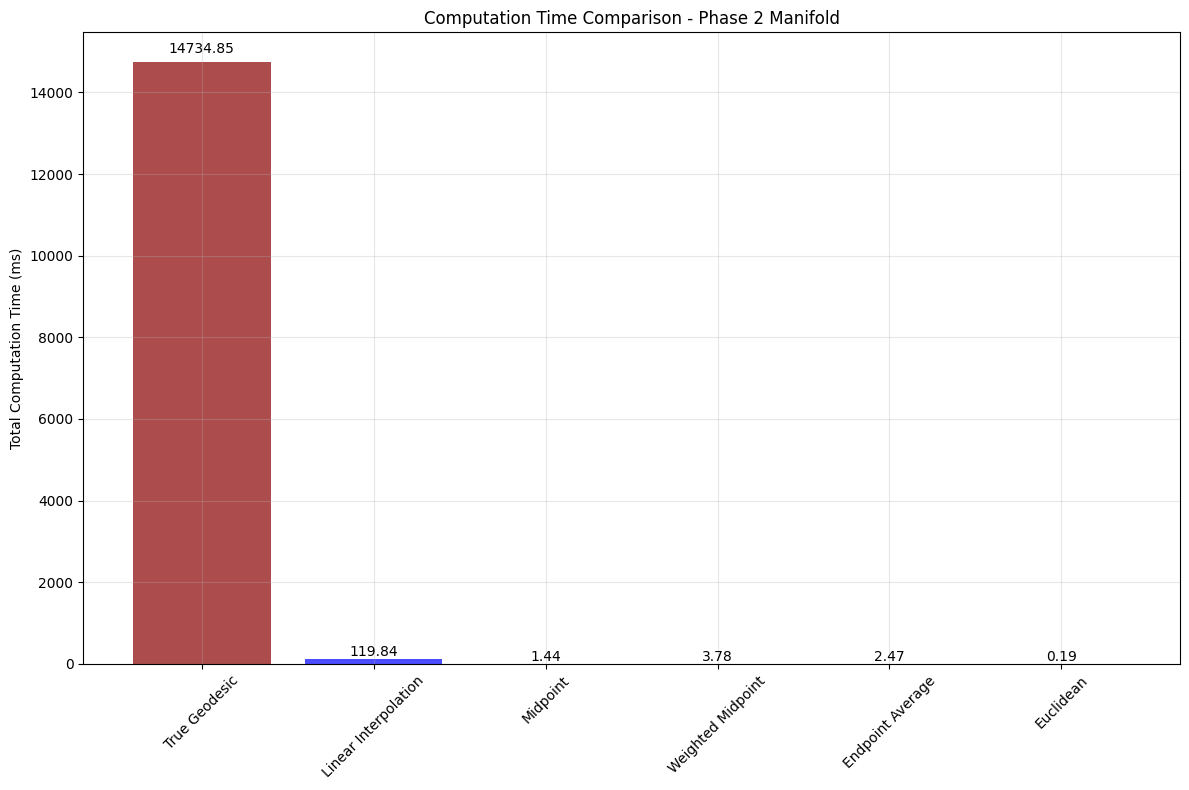

Generating example geodesic visualization...


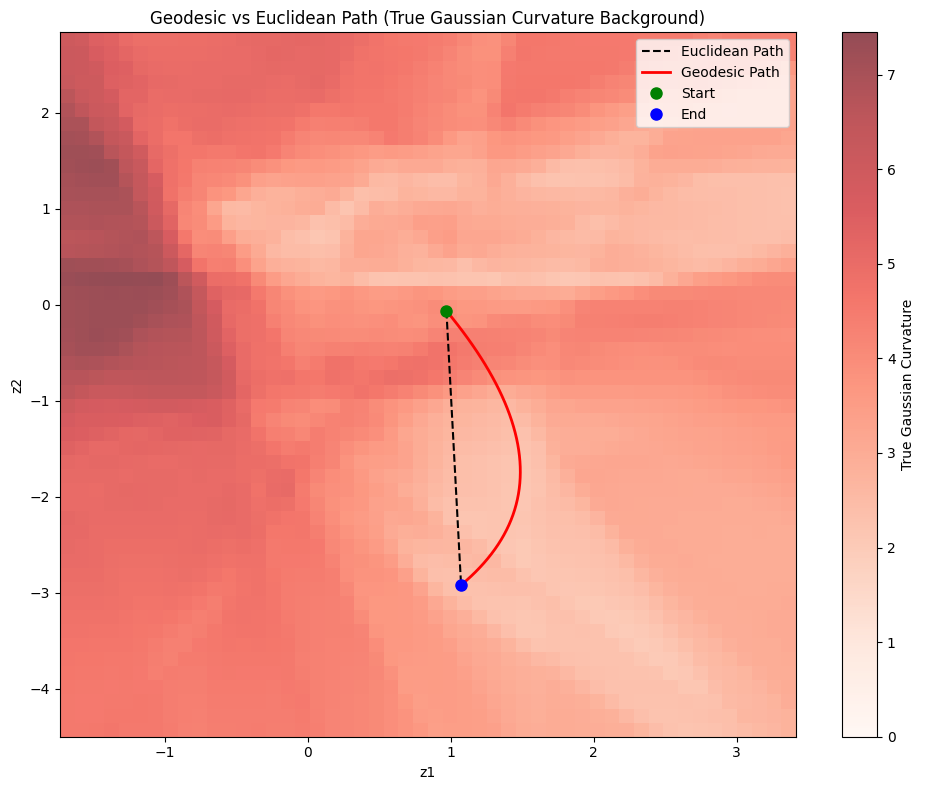

In [7]:
from framework.distanceApproxBenchmarker import DistanceApproxBenchmarker

num_dimensions = bounds.shape[0]

# Number of points to sample
num_points = 10

# Initialize an array to store the sampled points
test_points = np.zeros((num_points, num_dimensions))

# Sample random points
for i in range(num_points):
    for dim in range(num_dimensions):
        min_val, max_val = bounds[dim]
        test_points[i, dim] = np.random.uniform(min_val, max_val)


phase1_experiment = DistanceApproxBenchmarker(phase1_manifold, manifold_name="Phase 1")
results_phase1metrics = phase1_experiment.run_experiment(test_points, visualize=True)

phase2_experiment = DistanceApproxBenchmarker(phase2_manifold, manifold_name="Phase 2")
results_phase1metrics = phase2_experiment.run_experiment(test_points, visualize=True)

In [8]:
dists_phase1 = phase1_manifold.create_riemannian_distance_matrix(latent_points, phase1_manifold.linear_interpolation_distance)
dists_phase2 = phase2_manifold.create_riemannian_distance_matrix(latent_points, phase2_manifold.linear_interpolation_distance)

Calculating 124750 pairwise Riemannian distances using linear_interpolation_distance...


Calculating distances: 100%|██████████| 124750/124750 [06:15<00:00, 332.61it/s]


Distance matrix calculation complete.
Calculating 124750 pairwise Riemannian distances using linear_interpolation_distance...


Calculating distances: 100%|██████████| 124750/124750 [06:14<00:00, 332.84it/s]

Distance matrix calculation complete.


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot_correlogram(*correlation_matrices, titles=None, cmap='viridis', organ_names_dict=None, remove_diagonal=False, triangular=False, annot=False):
    """
    Plots multiple correlograms (NumPy arrays) in a row as subplots with a shared color scale and adjusted axis labels.

    Args:
        *correlation_matrices: Variable number of NumPy arrays (correlation matrices).
        titles: Optional list of titles for each correlogram. If None, default titles are used.
        cmap: Optional colormap for the heatmaps.
        organ_names_dict: Optional dictionary mapping indices to organ names. If provided, axis labels are adjusted.
    """

    num_matrices = len(correlation_matrices)

    if num_matrices == 0:
        print("No correlation matrices provided.")
        return

    if titles is None:
        titles = [f"Correlogram {i+1}" for i in range(num_matrices)]
    elif len(titles) != num_matrices:
        print("Number of titles does not match number of matrices.")
        titles = [f"Correlogram {i+1}" for i in range(num_matrices)]

    # Find the global min and max for the color scale
    global_min = min(np.nanmin(corr_matrix) for corr_matrix in correlation_matrices)
    global_max = max(np.nanmax(corr_matrix) for corr_matrix in correlation_matrices)

    if num_matrices == 1:
        plt.figure(figsize=(8 + 2*(organ_names_dict is not None), 8 + 2*(organ_names_dict is not None)))
    else:
        plt.figure(figsize=(12 * num_matrices, 12))

    for i, corr_matrix in enumerate(correlation_matrices):
        if remove_diagonal:
            np.fill_diagonal(corr_matrix, np.nan)
        if triangular:
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        else:
            mask = False

        plt.subplot(1, num_matrices, i + 1)
        ax = sns.heatmap(
            corr_matrix,
            annot=annot,
            cmap=cmap,
            fmt='.2f',
            linewidths=0,
            cbar_kws={"shrink": 0.8},
            annot_kws={"size": 12},
            square=True,
            linecolor='white',
            vmin=global_min,  # Set global min
            vmax=global_max,   # Set global max
            mask=mask
        )
        plt.title(titles[i])

        if organ_names_dict is not None:
            num_organs = corr_matrix.shape[0]
            if len(organ_names_dict) == num_organs:
                organ_names = [organ_names_dict.get(j, f"Index {j}") for j in range(num_organs)]
                ax.set_xticks(np.array(range(num_organs))+0.5)
                ax.set_xticklabels(organ_names, rotation=90)
                ax.set_yticks(np.array(range(num_organs))+0.5)
                ax.set_yticklabels(organ_names, rotation=0)
            else:
                print(f"Warning: Length of organ_names_dict ({len(organ_names_dict)}) does not match matrix size ({num_organs}).")

    plt.tight_layout()
    plt.show()
    return plt

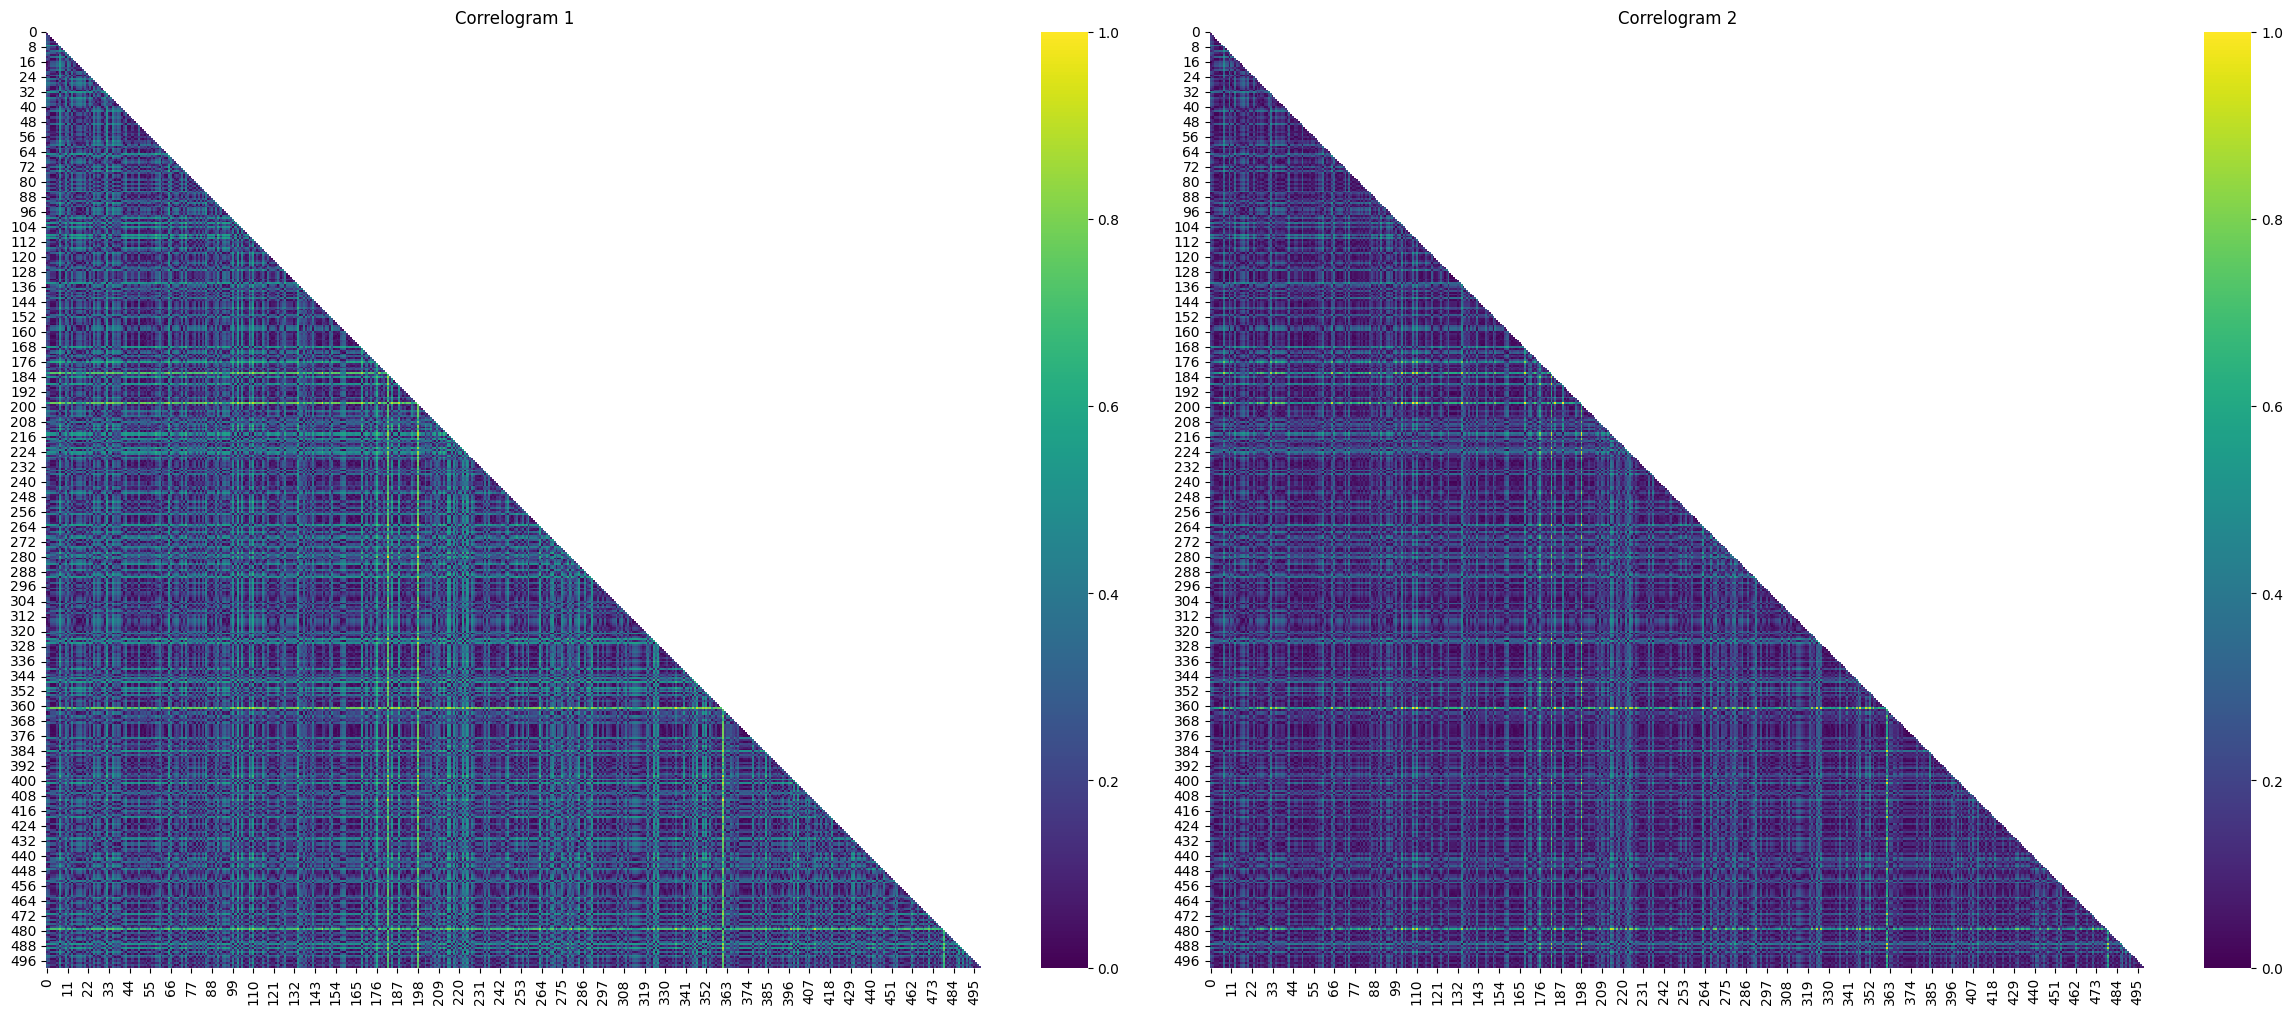

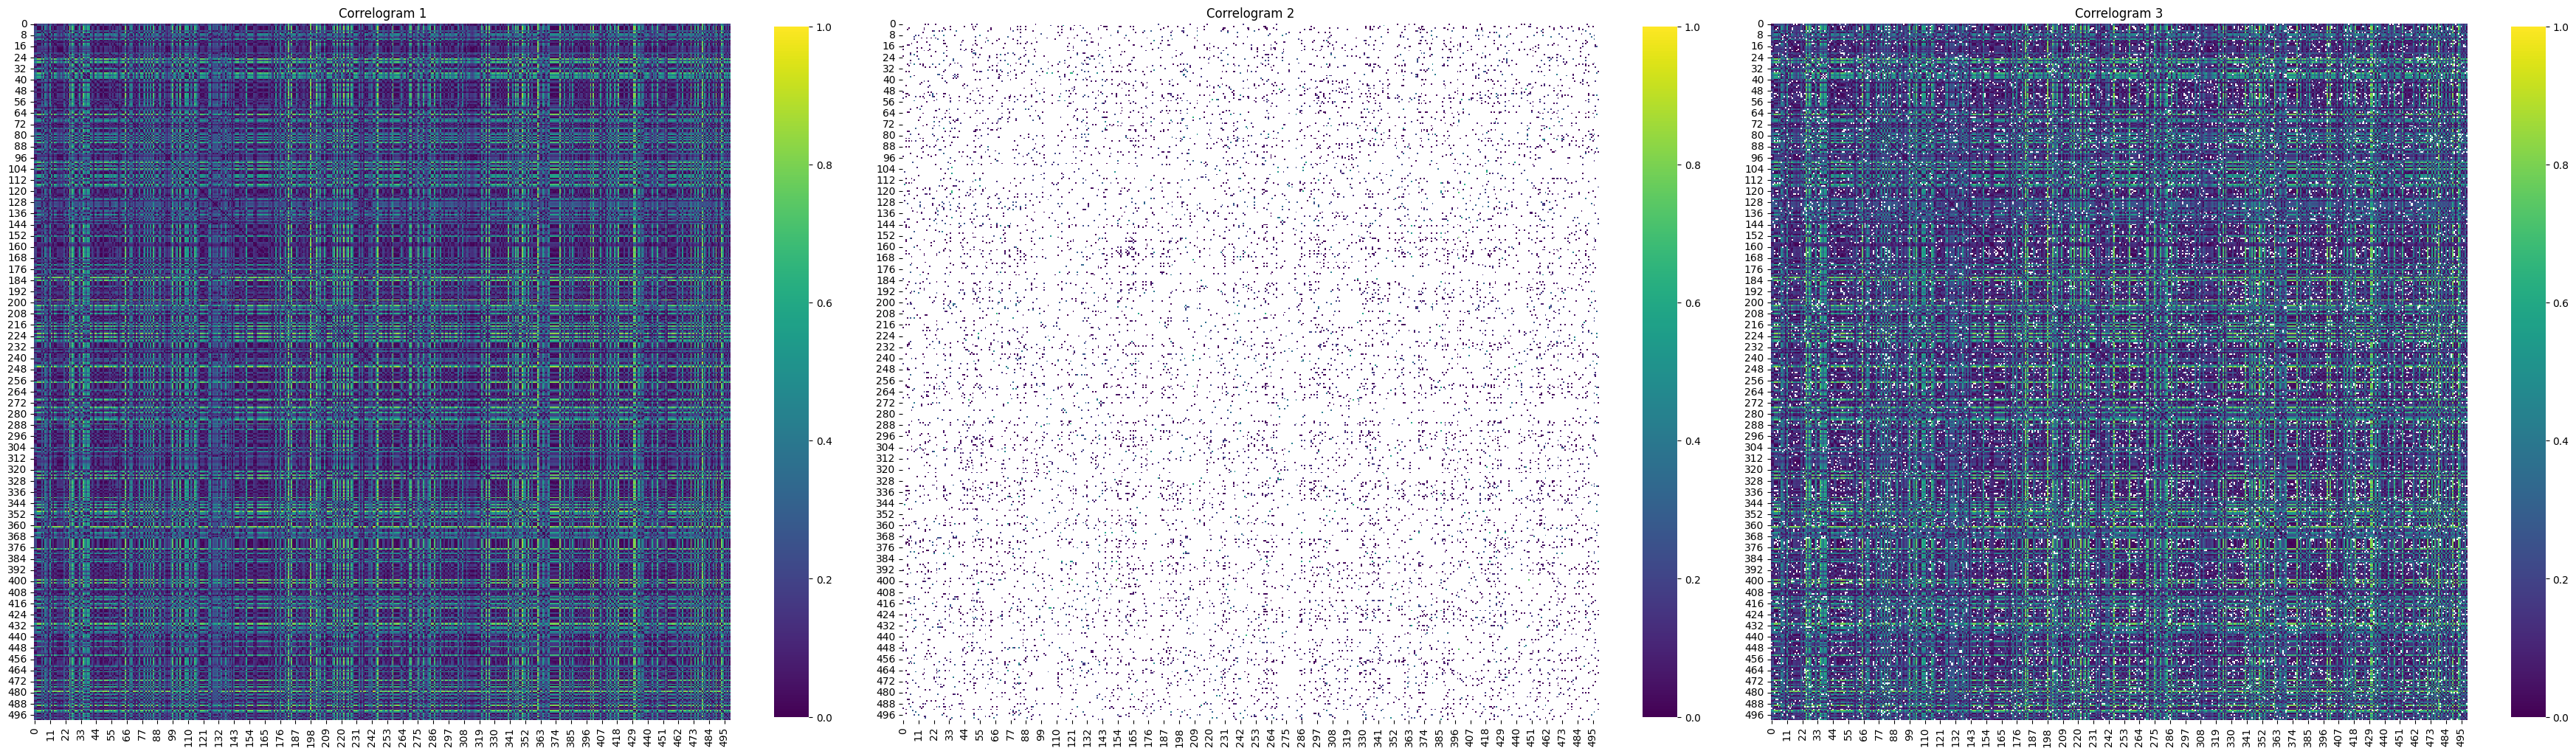

In [10]:
_ = plot_correlogram(dists_phase1/np.max(np.where(dists_phase1 > 0, dists_phase1, 0)), dists_phase2/np.max(np.where(dists_phase2 > 0, dists_phase2, 0)), remove_diagonal=True, triangular=True)
res = np.abs((dists_phase1 - dists_phase2)**1)
res_norm = res/np.max(res)
_ = plot_correlogram(res_norm, np.where(origial_adjacency_matrix - poisoned_adjacency_matrix != 0, res_norm, np.nan), np.where(origial_adjacency_matrix - poisoned_adjacency_matrix == 0, res_norm, np.nan))

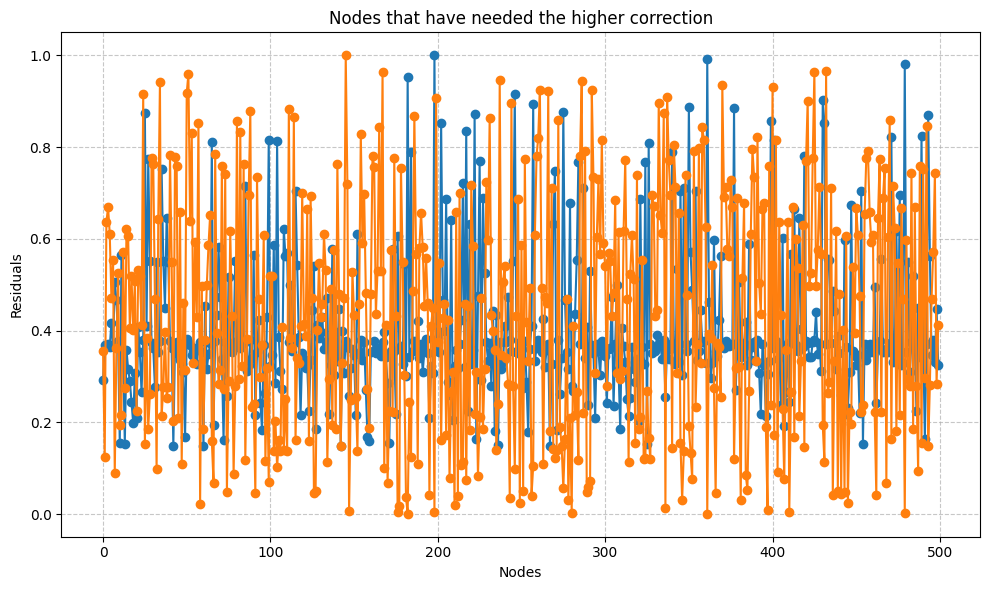

In [11]:
plt.figure(figsize=(10, 6)) # Set the size of the plot for better readability

plt.plot(np.sum(res, axis=0)/np.max(np.sum(res, axis=0)), marker='o', linestyle='-')
plt.plot(np.sum(poisoned_adjacency_matrix, axis=0)/np.max(np.sum(poisoned_adjacency_matrix, axis=0)), marker='o', linestyle='-')


# Add a horizontal line at y=0

# --- Customize the Plot ---
plt.xlabel('Nodes') # Label for the x-axis
plt.ylabel('Residuals') # Label for the y-axis, updated to reflect the ratio
plt.title('Nodes that have needed the higher correction') # Title of the plot, updated
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for easier reading
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()

In [17]:
np.corrcoef(np.sum(res, axis=0), np.sum(poisoned_adjacency_matrix, axis=0))

array([[1.        , 0.24104619],
       [0.24104619, 1.        ]])

In [18]:
np.corrcoef(res**2, poisoned_adjacency_matrix**2)

array([[ 1.        , -0.00671438,  0.2545206 , ..., -0.08305587,
         0.59364108, -0.13267019],
       [-0.00671438,  1.        ,  0.55631042, ..., -0.23475013,
        -0.15576621, -0.12146854],
       [ 0.2545206 ,  0.55631042,  1.        , ..., -0.27190244,
         0.07567129, -0.13451466],
       ...,
       [-0.08305587, -0.23475013, -0.27190244, ...,  1.        ,
         0.0357032 , -0.09014932],
       [ 0.59364108, -0.15576621,  0.07567129, ...,  0.0357032 ,
         1.        , -0.14104463],
       [-0.13267019, -0.12146854, -0.13451466, ..., -0.09014932,
        -0.14104463,  1.        ]])